Updates:
 - Corrected Diversity metric (passed the wrong variable).
 - Added refined business approach on Feature Engineering filtering
 - Added Price Bins within Feature Engineering
 - Passed text embeddings to the AutoEncoder to improve its performance
    - Goal is to improve the Collaborative filtering AutoEncoder with TF-IDF or BERT embeddings.
    - BERT Performs better with high n_components passed to the AutoEncoder
 - Added Validation Loss to the AutoEncoder
 - Added Custmized MSE Loss function that takes into account CosineSim
 - ToDo: Update function to recommend products within same price bins?

## Install Libraries

In [ ]:
# Install dependencies
!apt-get install -y cmake build-essential libopenblas-dev libomp-dev swig

# Clone the FAISS repository
!git clone --branch v1.7.2 https://github.com/facebookresearch/faiss.git
%cd faiss

# Clean up any previous builds
!rm -rf build

# Build FAISS with GPU support
!cmake -B build -DFAISS_ENABLE_GPU=ON -DCMAKE_BUILD_TYPE=Release
!make -C build -j$(nproc)

# Install FAISS Python bindings
%cd build/faiss/python
!python setup.py install

# Verify the installation
import faiss
print(f"FAISS version: {faiss.__version__}")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libopenblas-dev is already the newest version (0.3.20+ds-1).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
Suggested packages:
  libomp-14-doc swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14 swig swig4.0
0 upgraded, 5 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,854 kB of archives.
After this operation, 14.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp5-14 amd64 1:14.0.0-1ubuntu1.1 [389 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libomp-14-dev amd64 1:14.0.0-1ubuntu1.1 [347 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:4 http://archive.ubuntu.com/ubu

In [ ]:
!pip install umap-learn
# !pip uninstall umap

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/faiss-1.7.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install torch torchrec sentence_transformers

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/faiss-1.7.2-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.4/604.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 MB 3.6 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31528 sha256=30aac2872d1c3adb2c7b96d0588143e61b323b6855c1fa9d53ab3578139441ea
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built iopath


## Import Model and Libraries

In [ ]:
# @title Imports
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from time import sleep
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import numpy as np
from torch import Tensor
from sklearn.model_selection import train_test_split
import sys
import warnings
import collections
from collections import Counter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
import seaborn as sns
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import timedelta
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import faiss


warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Now using device: {device}")

print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

####################################################################################################
# Path of csv file
csv_path = "/content/drive/Othercomputers/My Laptop/Documents/LT-RecommendationSystem/amz_ca_total_products_data_processed.csv"

df_data = pd.read_csv(csv_path)
print("Import file shape: ", df_data.shape)

# Scaling factor used for debugging
df_data = df_data.sample(frac=1, random_state=42)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now using device: cuda
2.5.1+cu121
12.1
90100
Import file shape:  (2165926, 11)


<!-- ## 09/24 THETA DATA ANALYSIS -->

## EDA

In [ ]:
df_data
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2165926 entries, 1064924 to 1692743
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   asin               object 
 1   title              object 
 2   imgUrl             object 
 3   productURL         object 
 4   stars              float64
 5   reviews            int64  
 6   price              float64
 7   listPrice          float64
 8   categoryName       object 
 9   isBestSeller       bool   
 10  boughtInLastMonth  int64  
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 183.8+ MB


In [ ]:
df_data.describe(include='all')

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,categoryName,isBestSeller,boughtInLastMonth
count,2165926,2165920,2165926,2165926,2.165926e+06,2.165926e+06,2.165926e+06,2.165926e+06,2165926,2165926,2.165926e+06
unique,2165926,2065284,1902544,2165926,NaN,NaN,NaN,NaN,266,2,NaN
top,B0014JTAA2,Handmade pillow cover 16x16 inch Boho kelim pi...,https://m.media-amazon.com/images/I/01RmK+J4pJ...,https://www.amazon.ca/dp/B0014JTAA2,NaN,NaN,NaN,NaN,Baby,False,NaN
freq,1,464,1857,1,NaN,NaN,NaN,NaN,25664,2158272,NaN
mean,NaN,NaN,NaN,NaN,2.623661e+00,5.457391e+02,1.112207e+02,4.651383e+00,NaN,NaN,9.004624e+00
std,NaN,NaN,NaN,NaN,2.149905e+00,4.355225e+03,4.976653e+02,2.984392e+01,NaN,NaN,9.838265e+01
min,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,1.542000e+01,0.000000e+00,NaN,NaN,0.000000e+00
50%,NaN,NaN,NaN,NaN,4.000000e+00,5.000000e+00,2.742000e+01,0.000000e+00,NaN,NaN,0.000000e+00
75%,NaN,NaN,NaN,NaN,4.500000e+00,1.230000e+02,5.750000e+01,0.000000e+00,NaN,NaN,0.000000e+00


In [ ]:
# --- Check missing values ---
missing_values = df_data.isnull().sum()
print("Missing Values / NaN:\n", missing_values)

Missing Values / NaN:
 asin                 0
title                6
imgUrl               0
productURL           0
stars                0
reviews              0
price                0
listPrice            0
categoryName         0
isBestSeller         0
boughtInLastMonth    0
dtype: int64


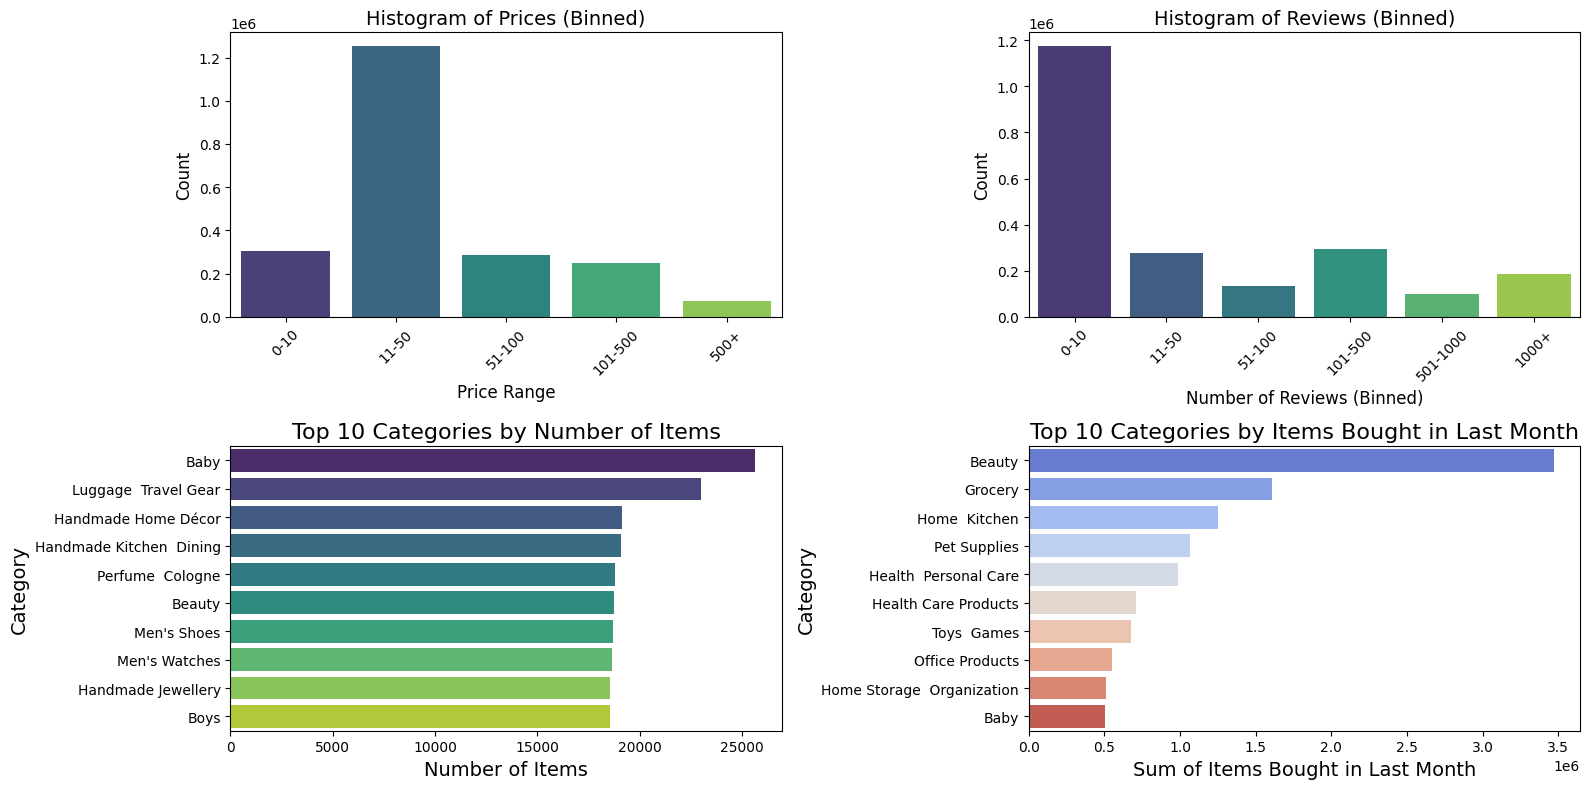

In [ ]:
# @title Plots
# --- Function to bin a column and plot ---
def plot_binned_histogram(df, column, bins, labels, title, x_label):
    binned_col = f"{column}_binned"
    df_data[binned_col] = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)

    # Plot histogram
    # plt.figure(figsize=(10, 6))
    plot = sns.countplot(data=df, x=binned_col, palette='viridis')
    plot.set_title(title, fontsize=14)
    plot.set_xlabel(x_label, fontsize=12)
    plot.set_ylabel("Count", fontsize=12)
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
    return plot

# --- Binning 'price'---
price_bins = [0, 10, 50, 100, 500, df_data['price'].max()]
price_labels = ['0-10', '11-50', '51-100', '101-500', '500+']

reviews_bins = [0, 10, 50, 100, 500, 1000, df_data['reviews'].max()]
reviews_labels = ['0-10', '11-50', '51-100', '101-500', '501-1000', '1000+']

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)  # (rows, columns, position)
plot_binned_histogram(
    df_data,
    column='price',
    bins=price_bins,
    labels=price_labels,
    title="Histogram of Prices (Binned)",
    x_label="Price Range"
)

plt.subplot(2, 2, 2)
plot_binned_histogram(
    df_data,
    column='reviews',
    bins=reviews_bins,
    labels=reviews_labels,
    title="Histogram of Reviews (Binned)",
    x_label="Number of Reviews (Binned)"
)

# --- Count the number of items per category ---
category_counts = df_data['categoryName'].value_counts()

plt.subplot(2, 2, 3)
sns.barplot(
    x=category_counts.values[:10],
    y=category_counts.index[:10],
    palette="viridis"
)
plt.title("Top 10 Categories by Number of Items", fontsize=16)
plt.xlabel("Number of Items", fontsize=14)
plt.ylabel("Category", fontsize=14)

# --- Group by 'categoryName' and calculate the sum of 'boughtInLastMonth' ---
bought_sum = df_data.groupby('categoryName')['boughtInLastMonth'].sum().sort_values(ascending=False)

# --- Plot the top 10 categories by sum of 'boughtInLastMonth' ---
plt.subplot(2, 2, 4)
sns.barplot(
    x=bought_sum.values[:10],
    y=bought_sum.index[:10],
    palette="coolwarm"
)
plt.title("Top 10 Categories by Items Bought in Last Month", fontsize=16)
plt.xlabel("Sum of Items Bought in Last Month", fontsize=14)
plt.ylabel("Category", fontsize=14)

plt.tight_layout()
plt.show()


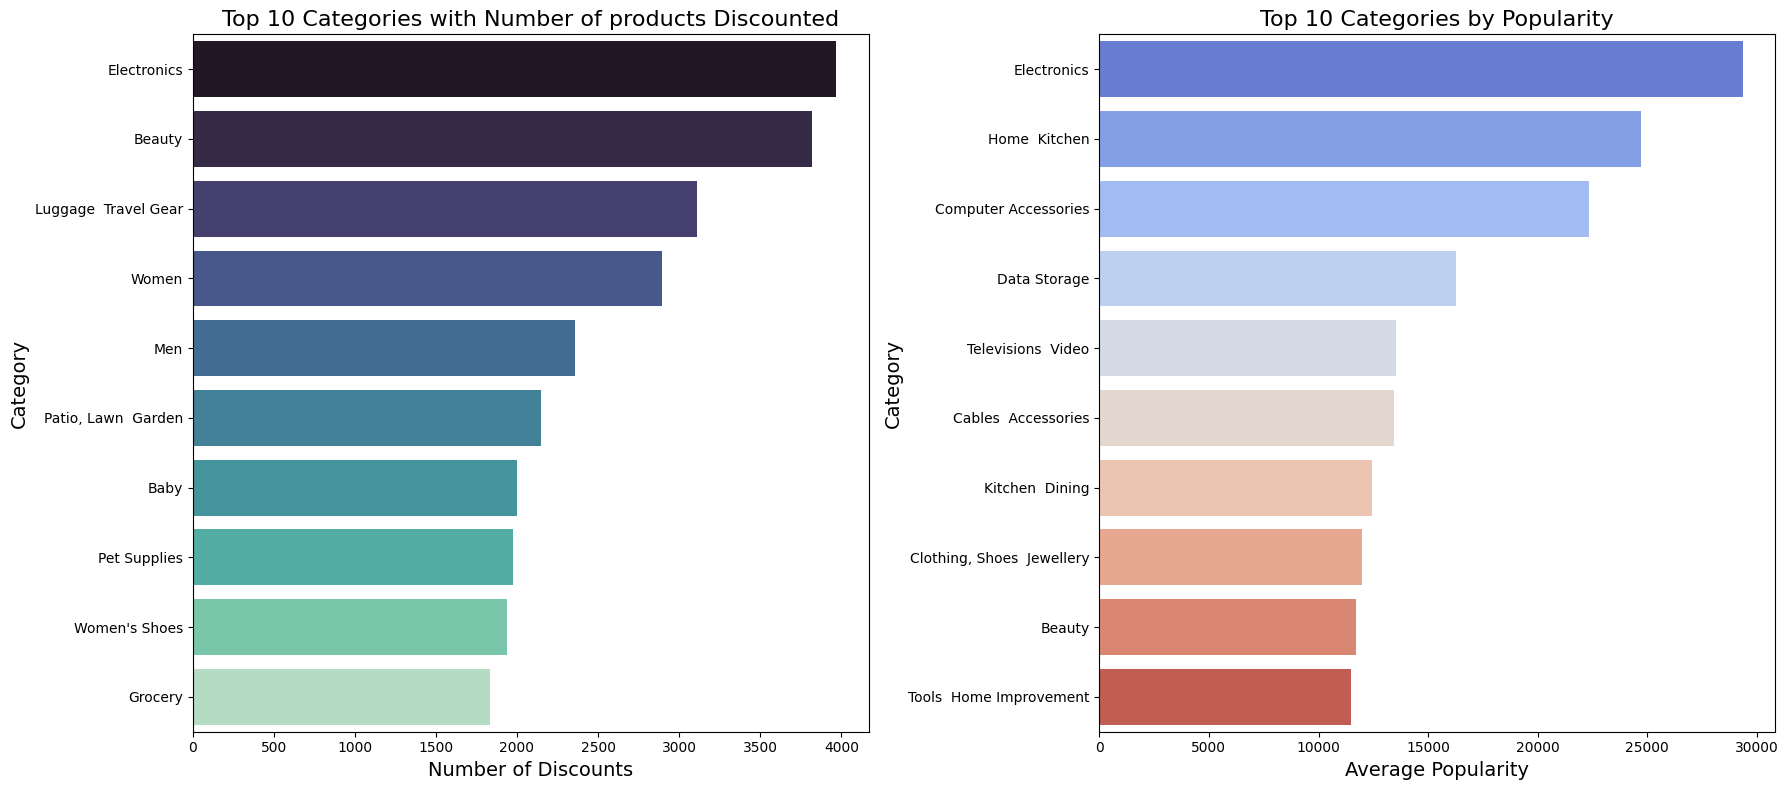

In [ ]:
# @title More Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column to identify discounted products
df_data['has_discount'] = df_data['listPrice'] > df_data['price']

# Group by 'categoryName' and count the number of discounts
discount_counts = df_data[df_data['has_discount']].groupby('categoryName').size().sort_values(ascending=False)

# Calculate Popularity
df_data['popularity'] = df_data['reviews'] * df_data['stars']
popularity_by_category = df_data.groupby('categoryName')['popularity'].mean().sort_values(ascending=False).head(10)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 10 Categories by Number of Discounts
sns.barplot(
    x=discount_counts.values[:10],
    y=discount_counts.index[:10],
    palette="mako",
    ax=axes[0]
)
axes[0].set_title("Top 10 Categories with Number of products Discounted", fontsize=16)
axes[0].set_xlabel("Number of Discounts", fontsize=14)
axes[0].set_ylabel("Category", fontsize=14)

# Top 10 Categories by Popularity
sns.barplot(
    x=popularity_by_category.values,
    y=popularity_by_category.index,
    palette="coolwarm",
    ax=axes[1]
)
axes[1].set_title("Top 10 Categories by Popularity", fontsize=16)
axes[1].set_xlabel("Average Popularity", fontsize=14)
axes[1].set_ylabel("Category", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


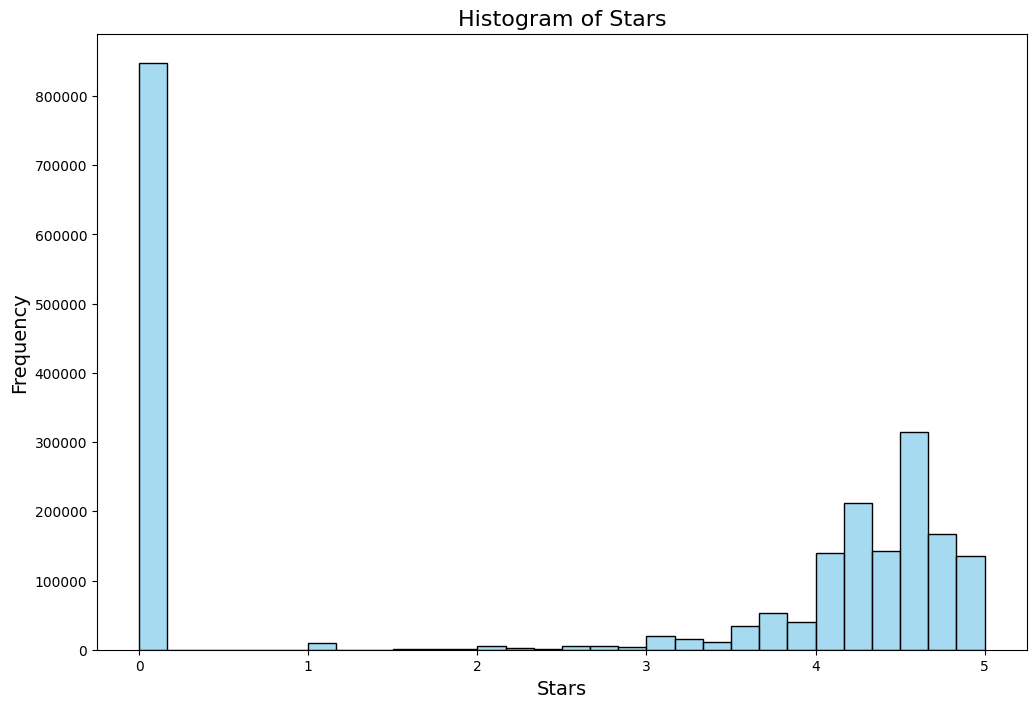

In [ ]:
# @title Star Hist
# Plot histogram for 'stars' column
plt.figure(figsize=(12, 8))
sns.histplot(data=df_data, x='stars', kde=False, bins=30, color='skyblue')
plt.title("Histogram of Stars", fontsize=16)
plt.xlabel("Stars", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()


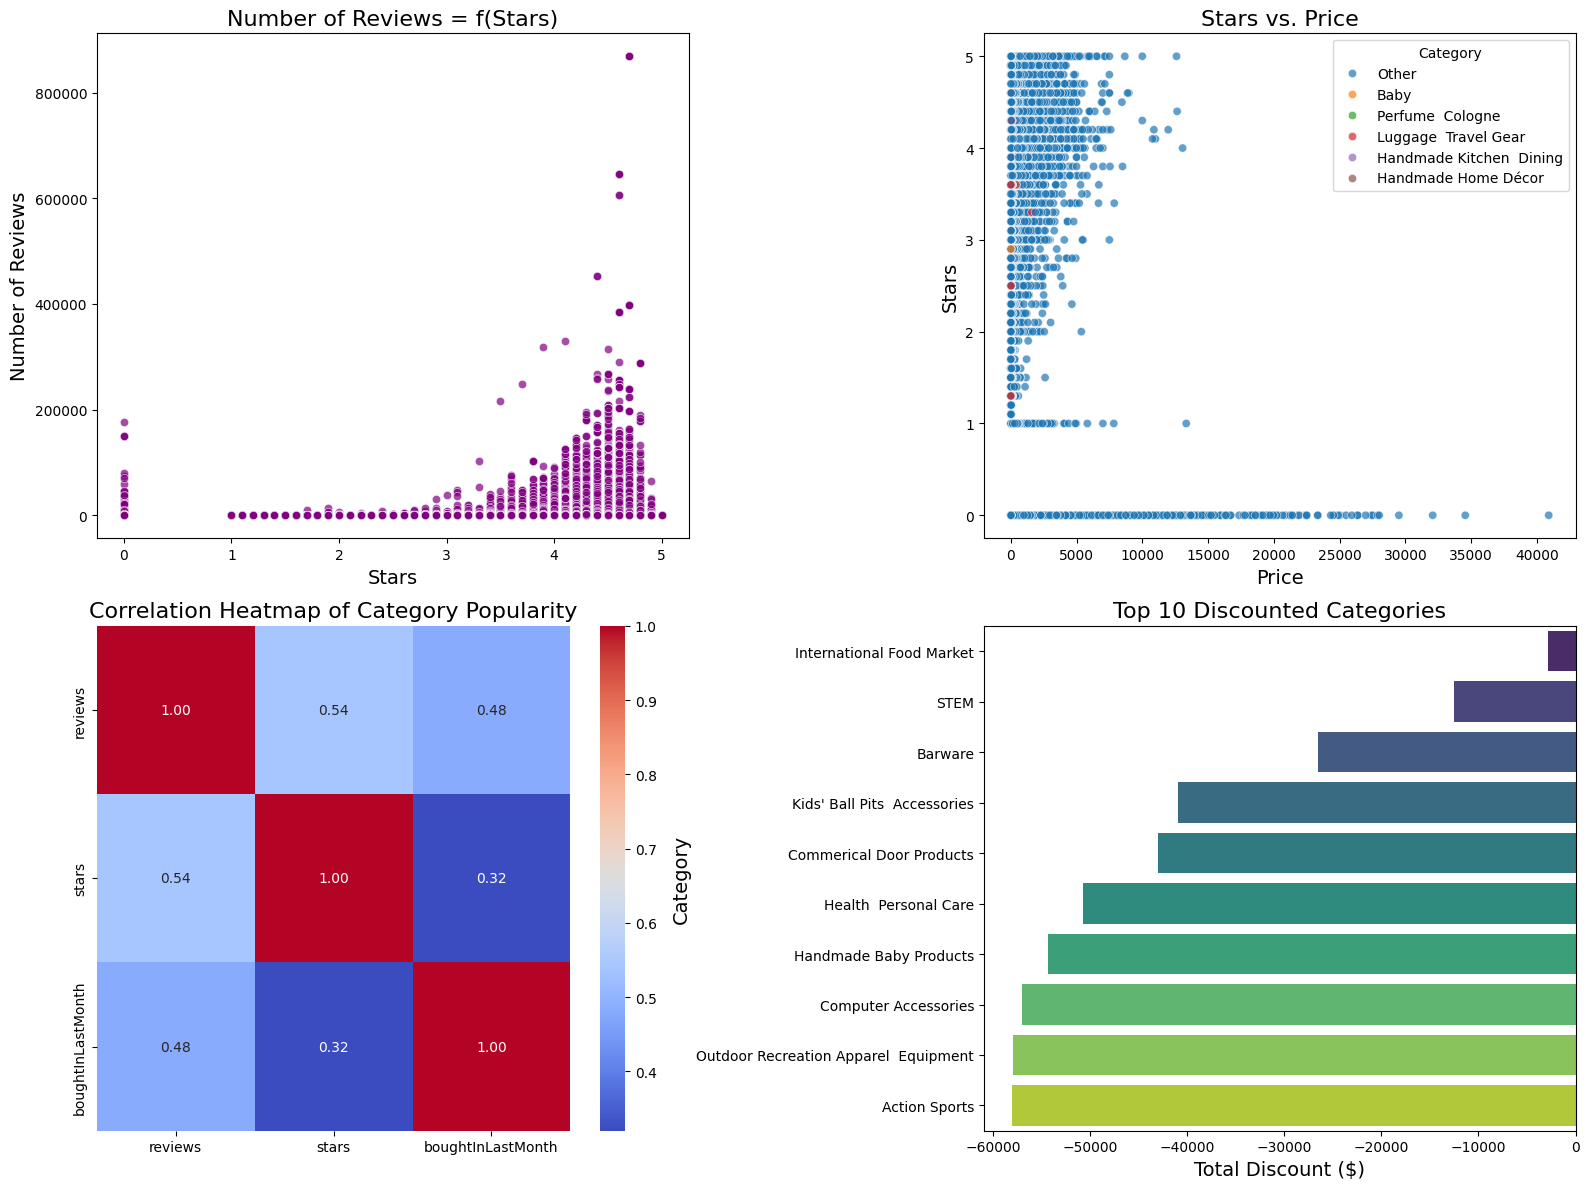

In [ ]:
# @title More Plots II
# --- Filter top 5 categories for the legend in Stars vs. Price ---
top_5_categories = df_data['categoryName'].value_counts().head(5).index
df_data['category_filtered'] = df_data['categoryName'].apply(
    lambda x: x if x in top_5_categories else 'Other'
)

# --- Create subplots ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- Number of Reviews = f(Stars) ---
sns.scatterplot(data=df_data, x='stars', y='reviews', alpha=0.7, color='purple', ax=axes[0, 0])
axes[0, 0].set_title("Number of Reviews = f(Stars)", fontsize=16)
axes[0, 0].set_xlabel("Stars", fontsize=14)
axes[0, 0].set_ylabel("Number of Reviews", fontsize=14)

# --- Stars vs. Price with filtered categories ---
sns.scatterplot(
    data=df_data, x='price', y='stars', hue='category_filtered', alpha=0.7, ax=axes[0, 1]
)
axes[0, 1].set_title("Stars vs. Price", fontsize=16)
axes[0, 1].set_xlabel("Price", fontsize=14)
axes[0, 1].set_ylabel("Stars", fontsize=14)
axes[0, 1].legend(title="Category", loc="upper right", ncol=1)

# --- Correlation Heatmap of Category Popularity ---
category_popularity = df_data.groupby('categoryName')[['reviews', 'stars', 'boughtInLastMonth']].sum()
sns.heatmap(
    category_popularity.corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=axes[1, 0]
)
axes[1, 0].set_title("Correlation Heatmap of Category Popularity", fontsize=16)

# --- Top 10 Discounted Categories ---
df_data['discount'] = df_data['listPrice'] - df_data['price']
discounts_by_category = df_data.groupby('categoryName')['discount'].sum().sort_values(ascending=False).head(10)
sns.barplot(
    x=discounts_by_category.values, y=discounts_by_category.index, palette='viridis', ax=axes[1, 1]
)
axes[1, 1].set_title("Top 10 Discounted Categories", fontsize=16)
axes[1, 1].set_xlabel("Total Discount ($)", fontsize=14)
axes[1, 1].set_ylabel("Category", fontsize=14)

# --- Adjust layout ---
plt.tight_layout()
plt.show()


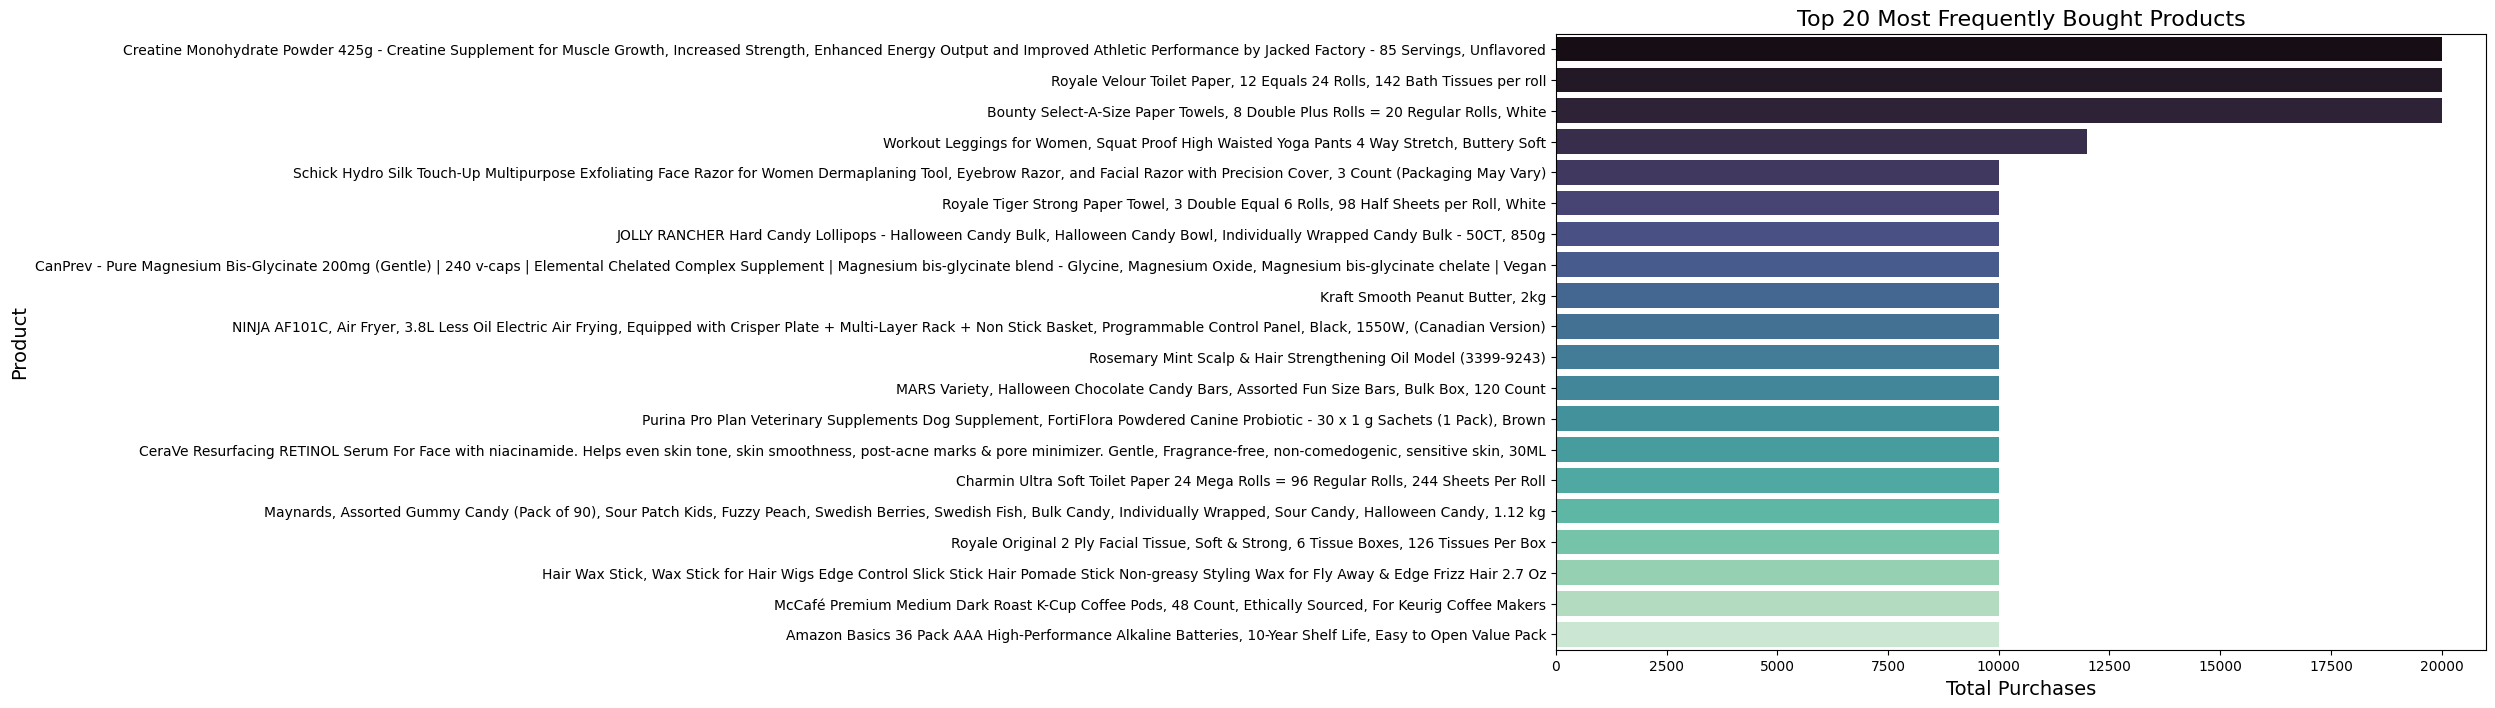

In [ ]:
# @title Bar Plot
product_frequency = df_data.groupby('title')['boughtInLastMonth'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=product_frequency.values, y=product_frequency.index, palette="mako")
plt.title("Top 20 Most Frequently Bought Products", fontsize=16)
plt.xlabel("Total Purchases", fontsize=14)
plt.ylabel("Product", fontsize=14)
plt.show()


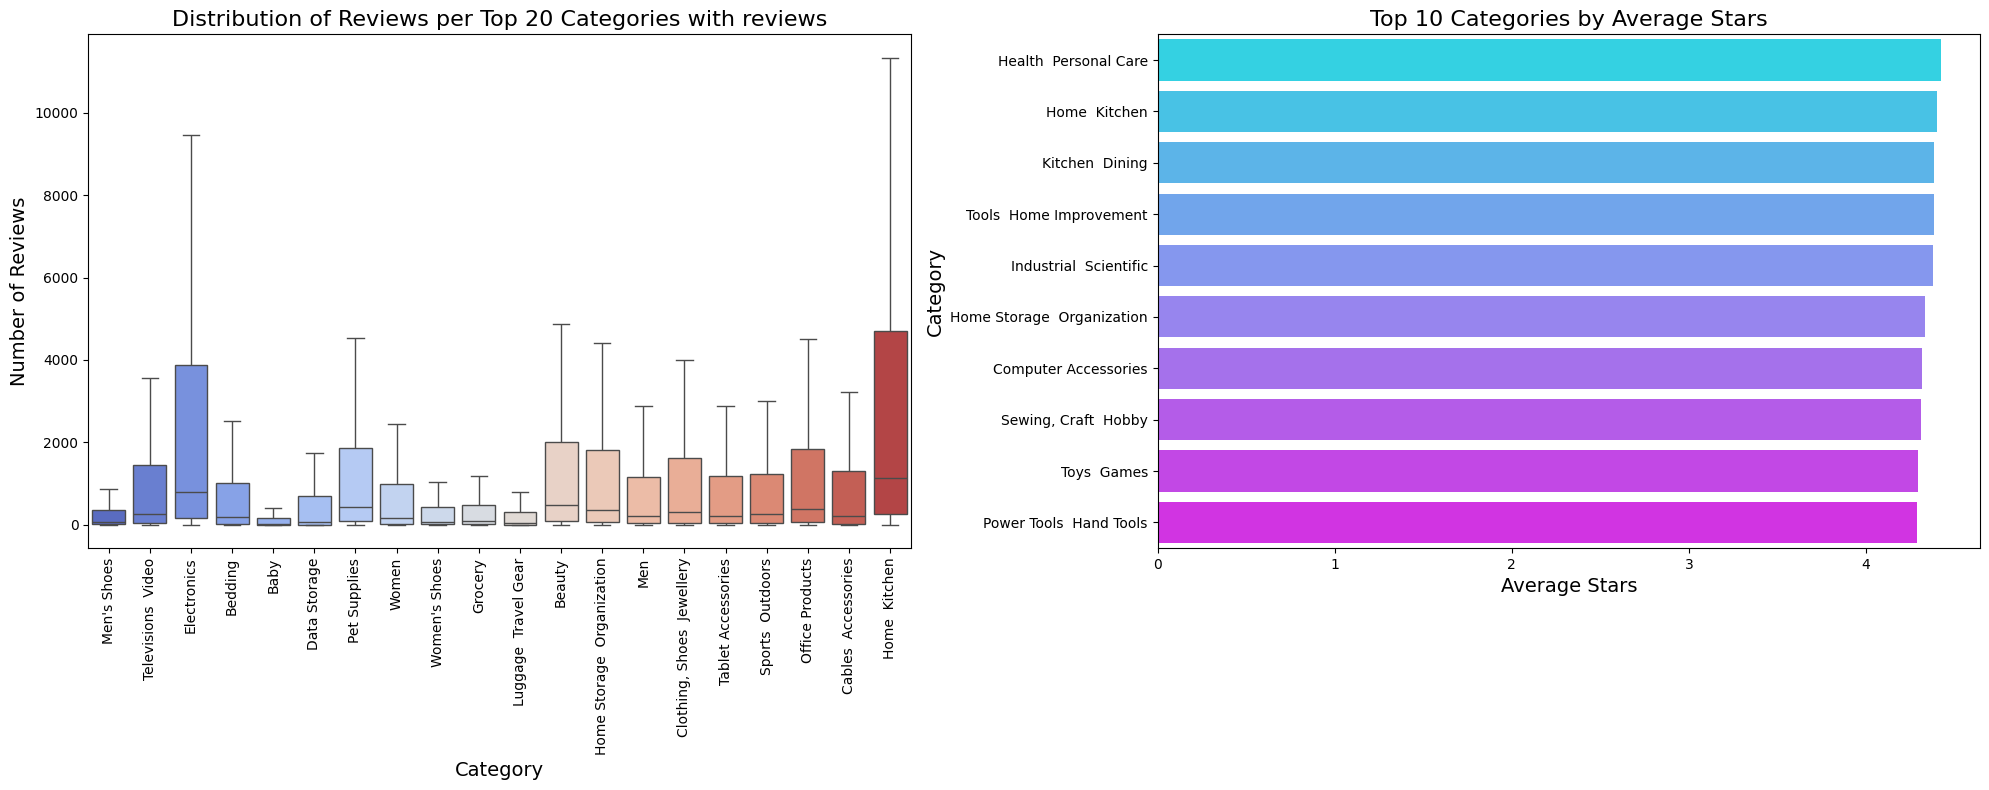

In [ ]:
# @title Plots
import matplotlib.pyplot as plt
import seaborn as sns

# --- Filter top 20 categories with the most reviews ---
top_20_review_categories = df_data.groupby('categoryName')['reviews'].sum().sort_values(ascending=False).head(20).index
df_top_reviews = df_data[df_data['categoryName'].isin(top_20_review_categories)]

# --- Calculate average stars by category for the second plot ---
avg_stars_by_category = df_data.groupby('categoryName')['stars'].mean().sort_values(ascending=False).head(10)

# --- Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- Distribution of Reviews per Top 20 Categories ---
sns.boxplot(
    data=df_top_reviews,
    x='categoryName',
    y='reviews',
    palette="coolwarm",
    showfliers=False,
    ax=axes[0]
)
axes[0].set_title("Distribution of Reviews per Top 20 Categories with reviews", fontsize=16)
axes[0].set_xlabel("Category", fontsize=14)
axes[0].set_ylabel("Number of Reviews", fontsize=14)
axes[0].tick_params(axis='x', rotation=90)

# --- Top 10 Categories by Average Stars ---
sns.barplot(
    x=avg_stars_by_category.values,
    y=avg_stars_by_category.index,
    palette="cool",
    ax=axes[1]
)
axes[1].set_title("Top 10 Categories by Average Stars", fontsize=16)
axes[1].set_xlabel("Average Stars", fontsize=14)
axes[1].set_ylabel("Category", fontsize=14)

# --- Adjust layout ---
plt.tight_layout()
plt.show()


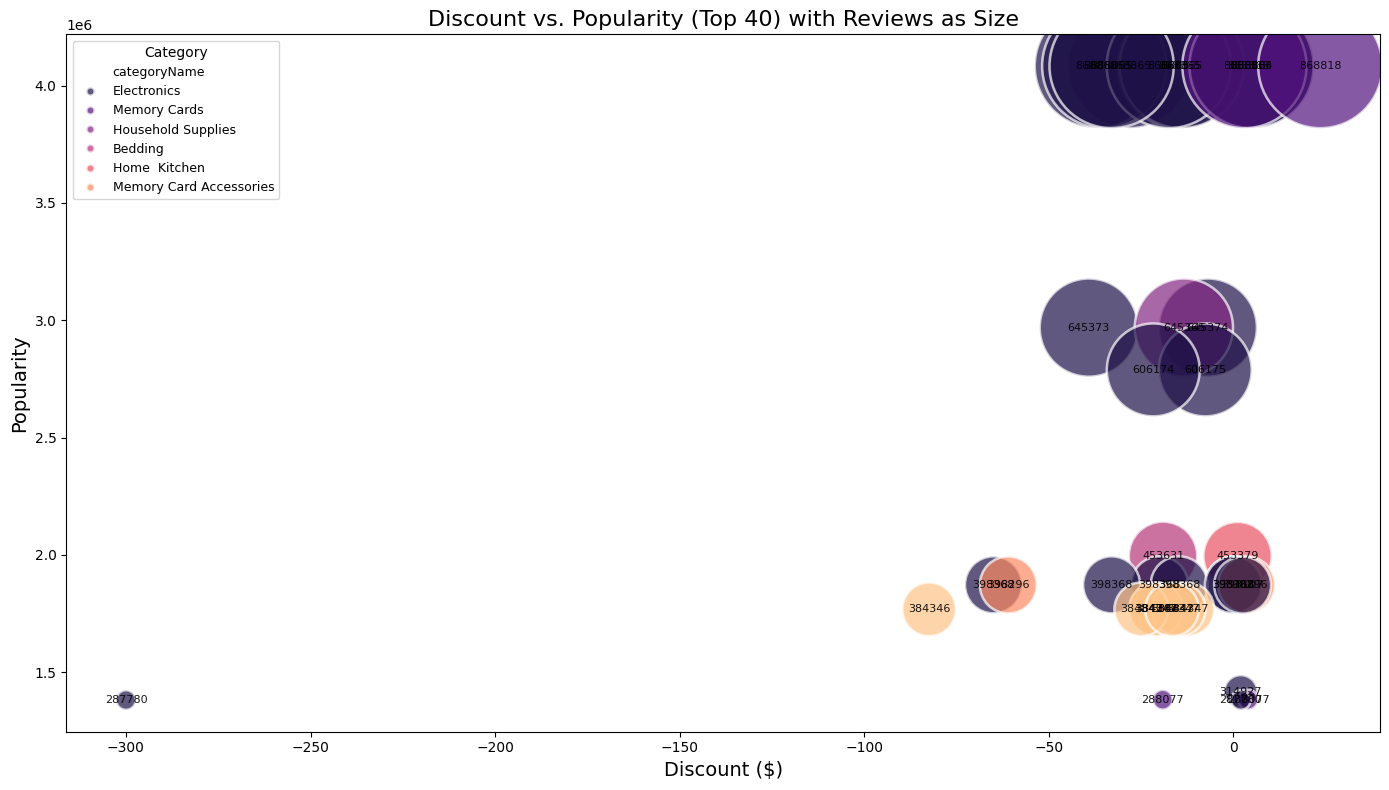

In [ ]:
# @title Bubble plots

# --- Sort the DataFrame by popularity in descending order ---
df_data_sorted = df_data.sort_values(by='popularity', ascending=False)

# --- Select the top 40 most popular points ---
df_top_40 = df_data_sorted.head(40)

# --- Create the scatter plot with size as the number of reviews ---
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(
    data=df_top_40,
    x='discount',
    y='popularity',
    hue='categoryName',
    size='reviews',           # Size based on the number of reviews
    sizes=(200, 8000),         # Adjust size range
    alpha=0.7,
    palette='magma'
)

# --- Add labels inside each circle ---
for i, row in df_top_40.iterrows():
    plt.text(
        row['discount'],
        row['popularity'],
        str(row['reviews']),    # Label is the number of reviews
        fontsize=8,
        ha='center',
        va='center',
        color='black',
        alpha=0.9
    )

# --- Title and axis labels ---
plt.title("Discount vs. Popularity (Top 40) with Reviews as Size", fontsize=16)
plt.xlabel("Discount ($)", fontsize=14)
plt.ylabel("Popularity", fontsize=14)

# --- Adjust legend to include all categories ---
handles, labels = scatter.get_legend_handles_labels()

plt.legend(
    handles=handles[:len(df_top_40['categoryName'].unique())],
    labels=labels,
    title="Category",
    loc="upper left",
    fontsize=9,
    title_fontsize=10
)

# --- Adjust layout and display ---
plt.tight_layout()
plt.show()


## Additional Plots

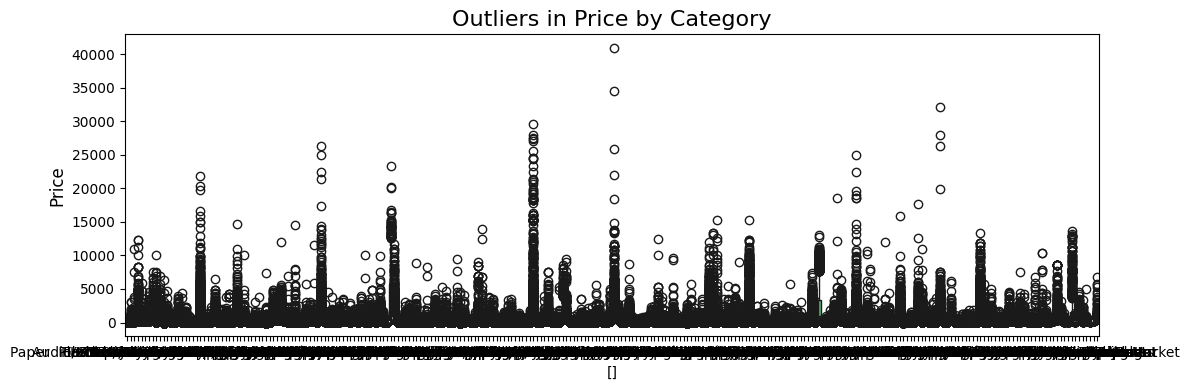

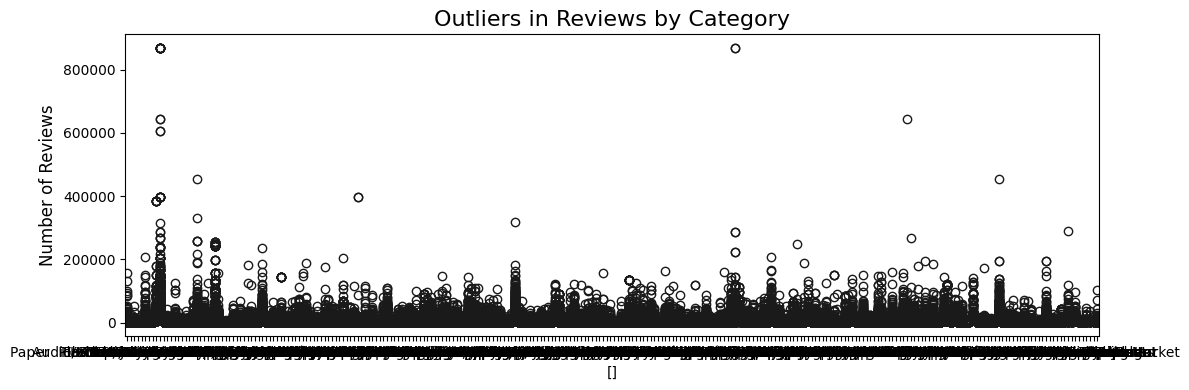

In [ ]:
# @title Outlier Detection Plots
import matplotlib.pyplot as plt
import seaborn as sns

# --- Boxplot for Price ---
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_data, x='categoryName', y='price', palette="viridis")
plt.title("Outliers in Price by Category", fontsize=16)
plt.xlabel([])
plt.ylabel("Price", fontsize=12)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Boxplot for Reviews ---
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_data, x='categoryName', y='reviews', palette="viridis")
plt.title("Outliers in Reviews by Category", fontsize=16)
plt.xlabel([])
plt.ylabel("Number of Reviews", fontsize=12)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


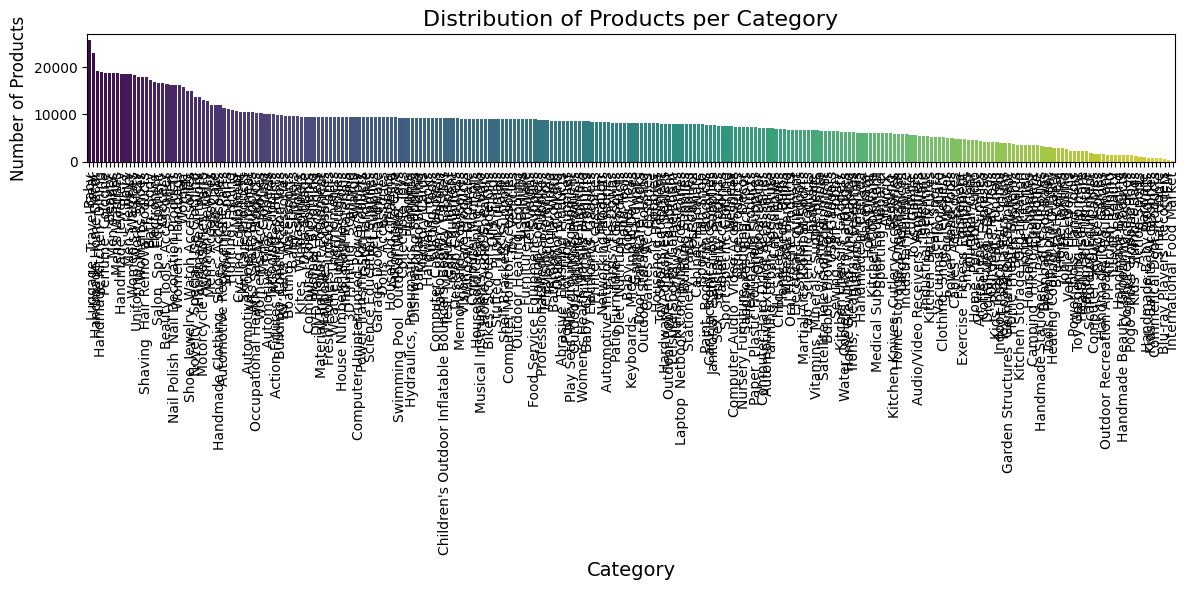

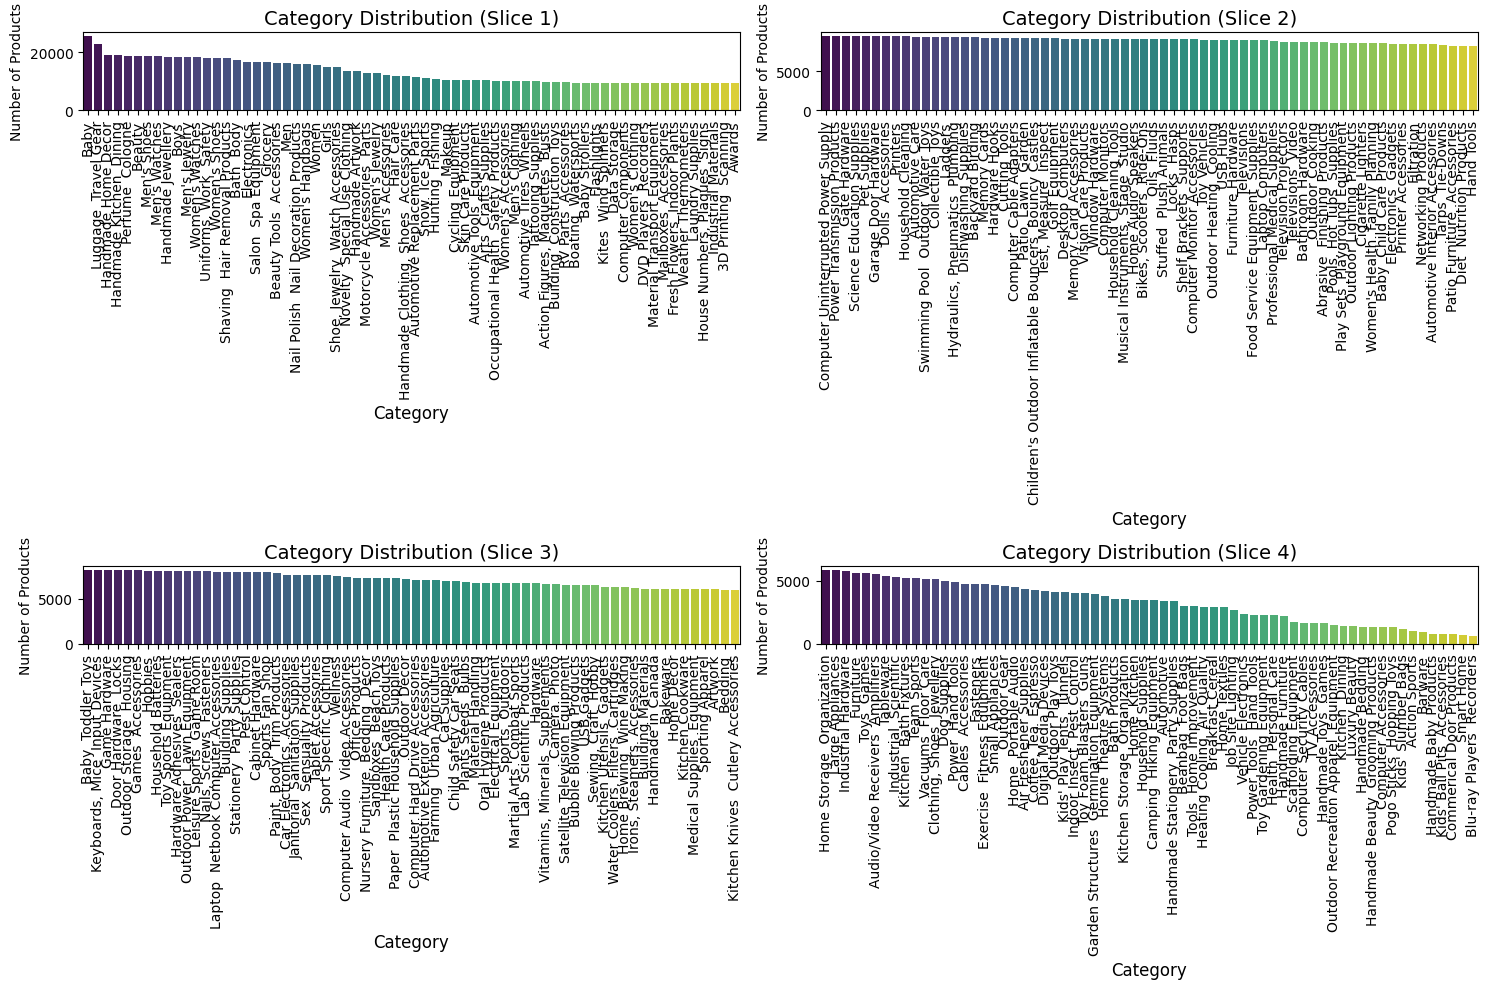

In [ ]:
# @title Distribution of nbr of product =f(categories)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Adjust figure size if needed
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.title("Distribution of Products per Category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Products", fontsize=12) # Reduced font size for y-label
plt.xticks(rotation=90)
plt.tight_layout()

# Calculate the number of items per slice
slice_size = len(category_counts) // 4

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Adjust figsize as necessary

for i in range(4):
    start_index = i * slice_size
    end_index = min((i + 1) * slice_size, len(category_counts))
    slice_data = category_counts[start_index:end_index]

    row = i // 2
    col = i % 2

    sns.barplot(ax=axes[row, col], x=slice_data.index, y=slice_data.values, palette="viridis")
    axes[row, col].set_title(f"Category Distribution (Slice {i+1})", fontsize=14)
    axes[row, col].set_xlabel("Category", fontsize=12)
    axes[row, col].set_ylabel("Number of Products", fontsize=10) #Reduced font size for y-label
    axes[row, col].tick_params(axis='x', rotation=90)
    plt.tight_layout()

plt.show()

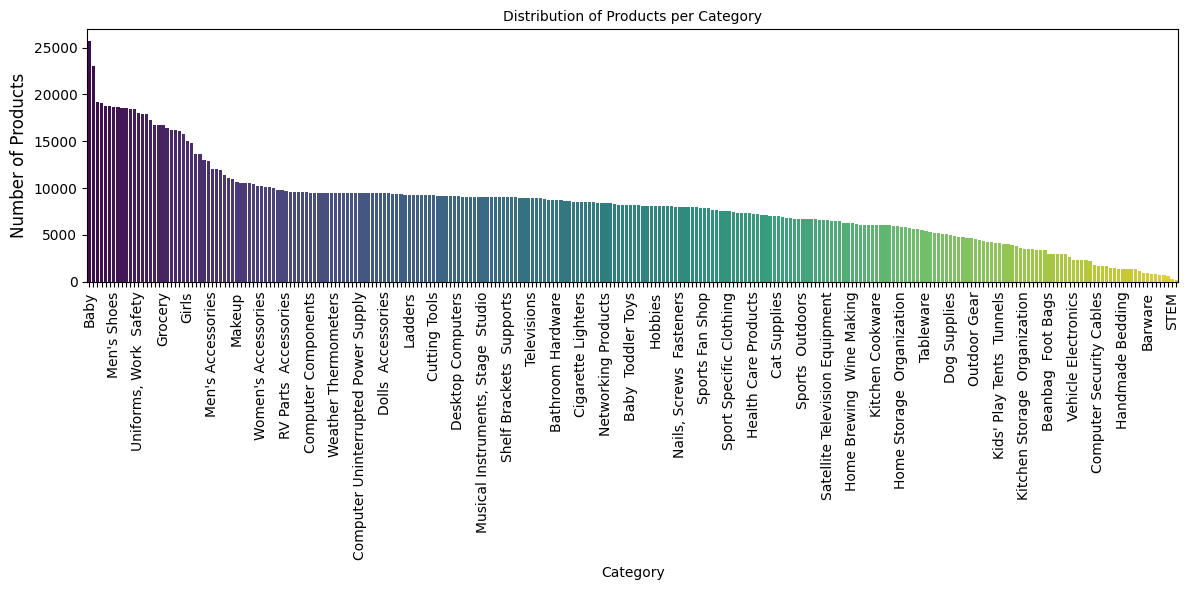

In [ ]:
# @title Distribution of Number of Products by Category
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))  # Adjust figure size if needed
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")

# Remove more x-tick labels by displaying only every 4th label
xticks = plt.gca().get_xticks()
xtick_labels = [label if i % 6 == 0 else "" for i, label in enumerate(category_counts.index)]
plt.gca().set_xticklabels(xtick_labels)

plt.title("Distribution of Products per Category", fontsize=10)
plt.xlabel("Category", fontsize=10)
plt.ylabel("Number of Products", fontsize=12)
plt.xticks(rotation=90)  # Slight rotation for better spacing
plt.tight_layout()


## Feature Eng

In [ ]:
data = df_data.copy()

# --- Memory optimization ---
data['price'] = pd.to_numeric(data['price'], downcast='float')
data['stars'] = pd.to_numeric(data['stars'], downcast='float')
data['listPrice'] = pd.to_numeric(data['listPrice'], downcast='float')
data['reviews'] = pd.to_numeric(data['reviews'], downcast='float')

# --- NEW FEATURES ---
# Discount and discount percentage
data['discount'] = data['listPrice'] - data['price']
data['discount_percentage'] = (data['discount'] / data['listPrice']).replace([np.inf, -np.inf], 0).fillna(0) * 100

# Title length
data['title_length'] = data['title'].fillna("").apply(len)

# Reviews per star
data['reviews_per_star'] = data['reviews'] / (data['stars'] + 1e-6)
data['reviews_per_star'] = data['reviews_per_star'].replace([np.inf, -np.inf], 0)

# Discount and Reviews_per_stars interactions
data['discount_and_stars'] = data['discount'] * data['stars']

# Discount and title length interactions?
data['discount_and_title_length'] = data['discount'] * data['title_length']

# Discount and reviews interactions?
data['discount_and_reviews'] = data['discount'] * data['reviews']

# High-rated binary column
data['high_rated'] = (data['stars'] >= 4).astype(int)

# Popularity score
data['popularity'] = data['reviews'] * data['stars']

# Encoding categoryName (Label Encoding)
data['category_encoded'] = data['categoryName'].astype('category').cat.codes

# Create price range bins
price_range_bins = pd.cut(data['price'], bins=[0, 50, 100, 200, float('inf')], labels=['0-50', '51-100', '101-200', '200+'],  include_lowest=True)
data['price_range_bins'] = price_range_bins

# Summary of new features
data.head()

,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,categoryName,isBestSeller,...,discount_percentage,title_length,reviews_per_star,discount_and_stars,discount_and_title_length,discount_and_reviews,high_rated,popularity,category_encoded,price_range_bins
1064924,B0014JTAA2,Seventh Generation Drawstrng Kitchen Bag 13 Ga...,https://m.media-amazon.com/images/I/81kggdVxfX...,https://www.amazon.ca/dp/B0014JTAA2,4.5,821.0,23.73,0.0,Paper Plastic Household Supplies,False,...,0.0,57,182.444404,-106.785,-1352.61,-19482.33,1,3694.5,192,0-50
1734235,B0CG2K84DQ,BESPORTBLE Fishing baits Lures Kit Bionic Lure...,https://m.media-amazon.com/images/I/61LgKQyVwf...,https://www.amazon.ca/dp/B0CG2K84DQ,0.0,0.0,0.00,0.0,Pest Control,False,...,0.0,80,0.000000,0.000,0.00,0.00,0,0.0,196,0-50
1650301,B0C5QMLPFY,Ladies Smart Watch Full Touch Fitness Watch Tr...,https://m.media-amazon.com/images/I/81Pgoquv3Z...,https://www.amazon.ca/dp/B0C5QMLPFY,0.0,0.0,557.32,0.0,Electronics Gadgets,False,...,0.0,176,0.000000,-0.000,-98088.32,-0.00,0,0.0,74,200+
1463834,B0BN9M8ZS1,MacQuarrie Scottish Clan History,https://m.media-amazon.com/images/I/916QaVVBQt...,https://www.amazon.ca/dp/B0BN9M8ZS1,0.0,0.0,12.98,0.0,Handmade Artwork,False,...,0.0,32,0.000000,-0.000,-415.36,-0.00,0,0.0,94,0-50
1923192,B0CC6V6PKX,Indoor/Outdoor Incandescent Round Rope Light -...,https://m.media-amazon.com/images/I/51y-6Zg1mo...,https://www.amazon.ca/dp/B0CC6V6PKX,0.0,0.0,71.13,0.0,Tarps Tie-Downs,False,...,0.0,57,0.000000,-0.000,-4054.41,-0.00,0,0.0,234,51-100


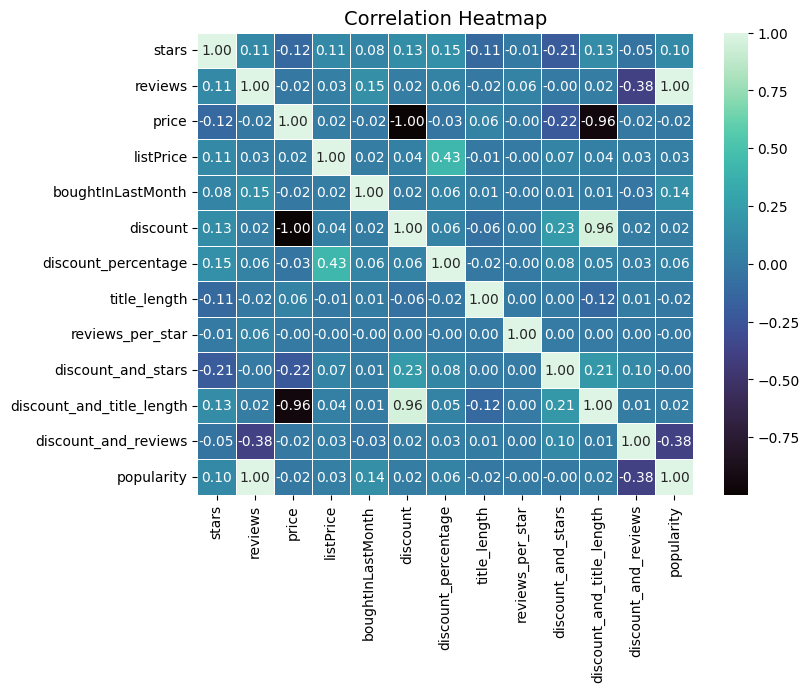

In [ ]:
# @title Correlation Matrix

columns_to_exclude = ['asin', 'title', 'imgUrl', 'productURL', 'categoryName', 'isBestSeller', 'high_rated', 'category_encoded', 'price_range_bins']
numerical_cols = [col for col in data.columns if col not in columns_to_exclude]

plt.figure(figsize=(8, 6))
corr = data[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap="mako", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

In [ ]:
# # Feature engineering and assumption:

# Removing redundant feature following correlation matrix
data = data.drop(columns=['discount', 'discount_and_title_length'])

# # --- Business Assumptions ---
# # Do we want to suggest products with 0 stars and 0 reviews?
# # I personally don't think and we should keep these products from the dataset, hence the recommendations

# # Excluding where we have strictly  less than 3 stars and where we have less than 30 reviews
data = data[(data['stars'] >= 3) & (data['reviews'] > 20)]
print("shape after excluding items with 1 stars and less than 5 reviews: ", data.shape)

data = data[(data['reviews_per_star'] >= 20)  ] # & (data['reviews'] > 50)
print("shape after excluding items with 1 stars and less than 5 reviews: ", data.shape)

shape after excluding items with 1 stars and less than 5 reviews:  (879076, 20)
shape after excluding items with 1 stars and less than 5 reviews:  (607650, 20)


In [ ]:
# @title Preprocessing pipeline

# Text Preprocessing pipeline
# --- Handles missin vals, convert to lowercase, remove special characters and tokenize the text ---
line_counter = 0
def preprocess_text(text, counter_step=50000):
    """
    Preprocesses a given text by performing the following steps:
    - Converts text to lowercase.
    - Removes special characters and punctuation.
    - Tokenizes the text into words.
    - Removes stopwords.
    - Applies lemmatization to each word.
    - Handles NaN values by returning an empty string.

    Additionally, tracks the number of processed lines with `counter_step` lines

    Args:
        text (str or float): The input text to preprocess. Can handle NaN values as floats.
        counter_step (int): Number of lines to process before printing a progress update. Default is 50,000.

    Returns:
        str: The cleaned and preprocessed text as a single string.
    """
    global line_counter

    # stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    if isinstance(text, float) and np.isnan(text):
        return ""  # Handle NaN values in text columns
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split() # tokenize the text
    # tokens = [stemmer.stem(word) for word in tokens if word not in stop_words] # stemmer isn't the best choice. leammatizer is.
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # Each word reduced to its based form eg: running -> run

    # Increment the counter
    line_counter += 1

    # Print update every counter_step lines
    if line_counter % counter_step == 0:
        print(f"Processed {line_counter} lines...")

    return ' '.join(tokens) # one final single string created

data['title'] = data['title'].apply(preprocess_text)
data['categoryName'] = data['categoryName'].apply(preprocess_text)

Processed 50000 lines...
Processed 100000 lines...
Processed 150000 lines...
Processed 200000 lines...
Processed 250000 lines...
Processed 300000 lines...
Processed 350000 lines...
Processed 400000 lines...
Processed 450000 lines...
Processed 500000 lines...
Processed 550000 lines...
Processed 600000 lines...
Processed 650000 lines...
Processed 700000 lines...
Processed 750000 lines...
Processed 800000 lines...
Processed 850000 lines...
Processed 900000 lines...
Processed 950000 lines...
Processed 1000000 lines...
Processed 1050000 lines...
Processed 1100000 lines...
Processed 1150000 lines...
Processed 1200000 lines...


In [ ]:
# @title StandardScaler and NaNs
# --- Numerical features used for the modelS ---
numerical_features = ['price', 'listPrice', 'reviews', 'stars', 'boughtInLastMonth', 'discount_percentage', 'high_rated', 'title_length', 'reviews_per_star', 'discount_and_stars', 'discount_and_reviews' , 'category_encoded', 'popularity']

# --- Applying StandardScaler on the numerical features ---
scaler = StandardScaler() # Will preserve the distribution
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# --- Reset Index and dropping columns we don't need ---
data.reset_index(drop=True, inplace=True)
if 'imgUrl' in data.columns:
    data=data.drop(columns=["imgUrl", "productURL"])

#---NaN CHECKS

# Count NaN values in each column
nan_counts = data.isnull().sum()

# Print the counts
print("NaN counts per column:\n", nan_counts)

# Total number of NaNs in the DataFrame
total_nan_count = nan_counts.sum()
print(f"\nTotal number of NaN values: {total_nan_count}")

print("shape df before Nan Drop: ", data.shape)
data.dropna(inplace=True)
print("shape df post Nan Drop: ", data.shape)

NaN counts per column:
 asin                    0
title                   0
stars                   0
reviews                 0
price                   0
listPrice               0
categoryName            0
isBestSeller            0
boughtInLastMonth       0
discount_percentage     0
title_length            0
reviews_per_star        0
discount_and_stars      0
discount_and_reviews    0
high_rated              0
popularity              0
category_encoded        0
price_range_bins        0
dtype: int64

Total number of NaN values: 0
shape df before Nan Drop:  (607650, 18)
shape df post Nan Drop:  (607650, 18)


## FE Pots

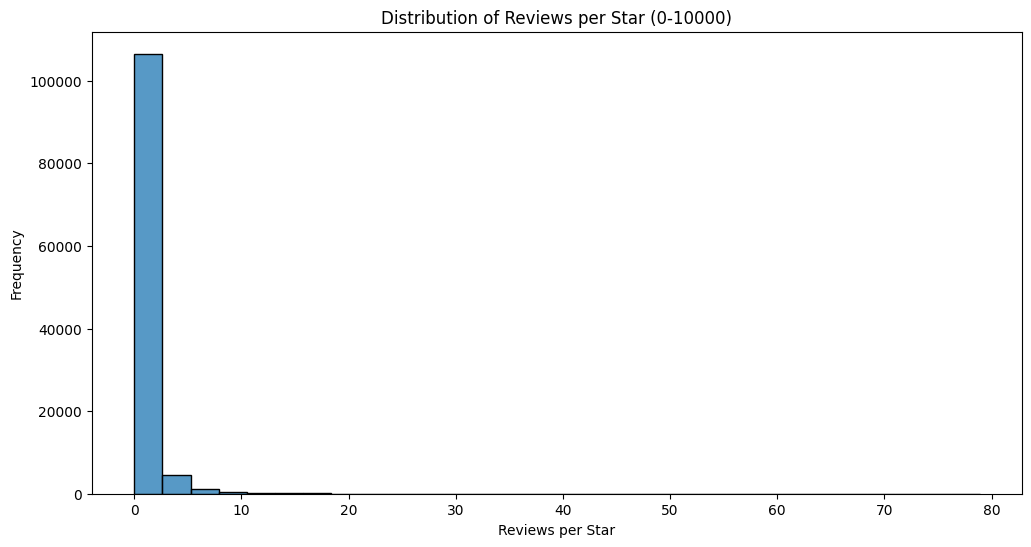

In [ ]:
# @title Distribution reviews per stars
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame from the previous code
plt.figure(figsize=(12, 6))
sns.histplot(data=data[data['reviews_per_star'].between(0, 80)], x='reviews_per_star', bins=30, kde=False)
plt.title('Distribution of Reviews per Star (0-10000)')
plt.xlabel('Reviews per Star')
plt.ylabel('Frequency')
plt.show()

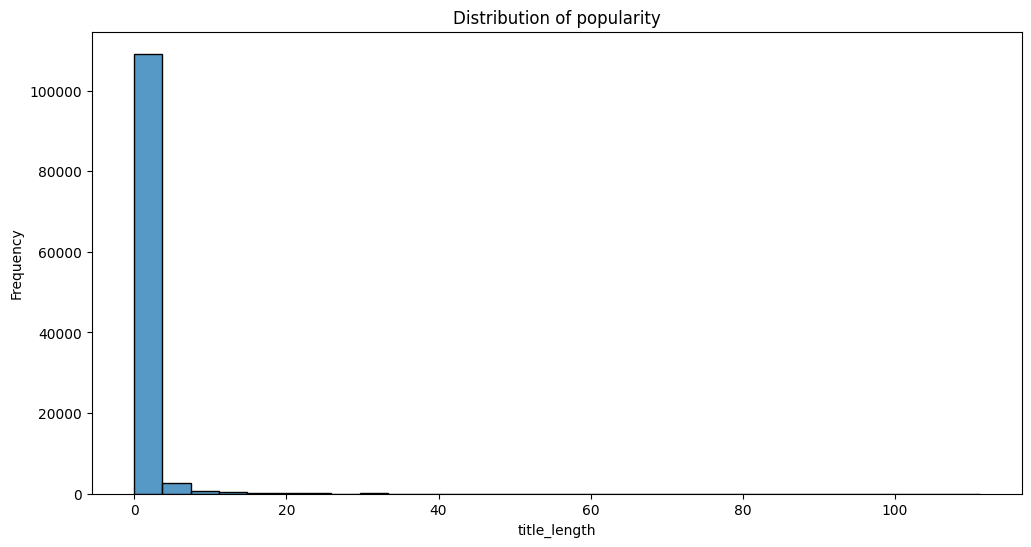

In [ ]:
# @title Distribution popularity
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame from the previous code
plt.figure(figsize=(12, 6))
sns.histplot(data=data[data['popularity'].between(0, 3000)], x='popularity', bins=30, kde=False)
plt.title('Distribution of popularity')
plt.xlabel('title_length')
plt.ylabel('Frequency')
plt.show()

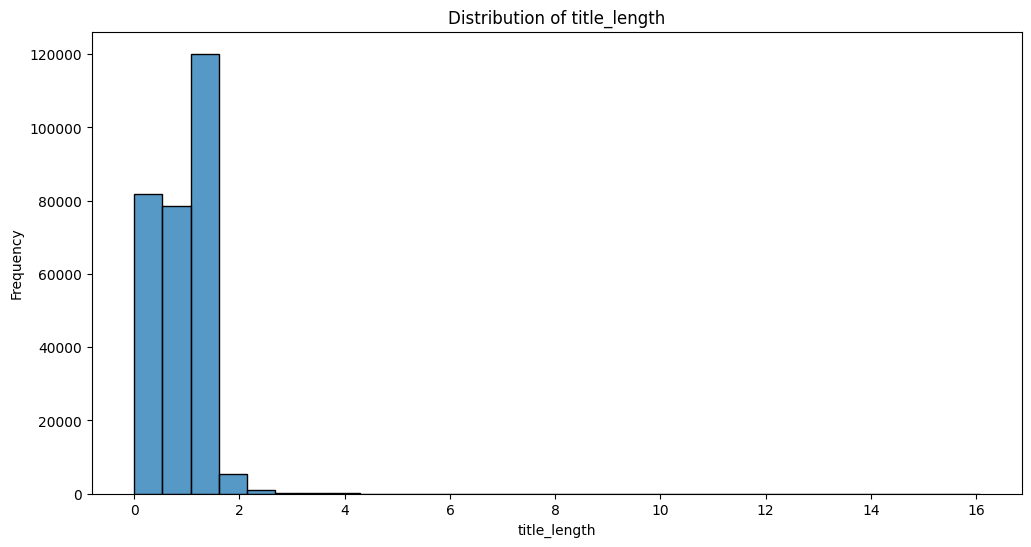

In [ ]:
# @title Distribution title_length
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame from the previous code
plt.figure(figsize=(12, 6))
sns.histplot(data=data[data['title_length'].between(0, 300)], x='title_length', bins=30, kde=False)
plt.title('Distribution of title_length')
plt.xlabel('title_length')
plt.ylabel('Frequency')
plt.show()

## Model -> Content Based Filtering

In [ ]:
# @title 1 - Content Based on BERT SentenceTransformer

data['content'] = data['title'] + ' ' + data['categoryName']

model_stbert = SentenceTransformer('all-MiniLM-L6-v2', device=device) # removed all-mpnet-base-v2, and used MiniLM, much faster
model_stbert.half()  # Convert parameters to FP16, reduce memory usage on GPU

titles = data['content'].tolist()
batch_size_bert = 524_288 #524_288 #65_536 #8192 #very high batch value, likely bc data['content'] is relatively small
title_dataloader = DataLoader(titles, batch_size=batch_size_bert, shuffle=False)

# Generate embeddings in batches
title_embeddings = []
for batch in title_dataloader:
    # batch is a list of strings
    with torch.no_grad():
        embeddings = model_stbert.encode(
            batch,
            convert_to_tensor=True,
            show_progress_bar=True
        )
    # Move to CPU and convert to numpy to avoid holding everything in GPU memory
    title_embeddings.append(embeddings.cpu().numpy())

# Concatenate all batch arrays
title_embeddings = np.vstack(title_embeddings)   # Shape: [N, 768] for all-mpnet-base-v2 or shape [N, 384] for all-MiniLM-L6-v2

svd = TruncatedSVD(n_components=300) #used a reduction to output dim=50
svd.fit(title_embeddings)
reduced_embeddings = svd.fit_transform(title_embeddings)

# # --- Look for Optimal n component ---
# svd_variance = 0.7
# cumulative_variance = svd.explained_variance_ratio_.cumsum()
# optimal_components = (cumulative_variance >= svd_variance).argmax() + 1
# print(f"Optimal number of components for {100*svd_variance}% variance: {optimal_components}")
# svd = TruncatedSVD(n_components=optimal_components)  # Reduction to [N, n_components] dims
# reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix) # Shape [N, n_components]

# -- Converts to Float32 for FAISS ---
reduced_embeddings = reduced_embeddings.astype(np.float32)

# print("Explained variance ratio:", svd.explained_variance_ratio_)
# Calculate the mean of the title embeddings
embedding_mean = title_embeddings.mean()
print("Mean of embeddings:", embedding_mean)
print("Total explained variance:", svd.explained_variance_ratio_.sum())
print("reduced_embeddings shape:", reduced_embeddings.shape)

# L2-normalize the n_components-dim embeddings
# l2 is the equivalent of cosine similarity, equivalent of NearestNeighbors(metric="cosine")
reduced_embeddings = normalize(reduced_embeddings, norm='l2', axis=1)
d = reduced_embeddings.shape[1]  # shape of n_components=50
res = faiss.StandardGpuResources()  # Use a single GPU

index_flat = faiss.IndexFlatIP(d)   # CPU index for inner product
index = faiss.index_cpu_to_gpu(res, 0, index_flat)  # 0 = GPU device id

# Add all vectors
index.add(reduced_embeddings)  # shape [N, d], float32
top_10 = 10 # number of closest neighbors we want to keep. We have already calculated the embedding space
distances_content, indices_content = index.search(reduced_embeddings, top_10)
# distances_content and indices_content -> both shape: [N, k]

print("distances_content shape:", distances_content.shape)
print("indices_content shape:", indices_content.shape)

# Sanity check example for the first item
print("Item 0 neighbors:", indices_content[0])
print("Item 0 indices_content (IP ~ Cosine):", distances_content[0])


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/16384 [00:00<?, ?it/s]

Batches:   0%|          | 0/2606 [00:00<?, ?it/s]

Mean of embeddings: -0.0002778
Total explained variance: 16.97067
reduced_embeddings shape: (607650, 300)
distances_content shape: (607650, 10)
indices_content shape: (607650, 10)
Item 0 neighbors: [     0 281411 338599 549552 566831 427824  91455 284337 381615  17449]
Item 0 indices_content (IP ~ Cosine): [0.99999994 0.913263   0.8281536  0.8230624  0.81988573 0.81808996
 0.8153251  0.8144846  0.8052909  0.7983342 ]


In [ ]:
# @title 2 - Content Based TfidfVectorizer

# --- Combine text fields for a richer representation ---
data['content'] = data['title'] + ' ' + data['categoryName']

# --- Vectorize Content using TF-IDF ---
tfidf = TfidfVectorizer(
    sublinear_tf=True, # Sublinear is for when repetitive words like "good", "great" or content varies in length (short vs long descriptions)
    ngram_range=(1, 2), # Ngrams Includes both unigrams (single words) and bigrams (two-word sequences) -> "high", "quality" vs "high quality"
    max_features=2000, # limit the number of words
    max_df=0.3 # limits the number of repetitive words within text to save memory and limit imbalance. Terms appearing more than 30% are excluded
)
tfidf_matrix = tfidf.fit_transform(data['content'])  # shape: [N, max_features] here max_features = 2000

# Convert to CSR (if not already)
tfidf_matrix = csr_matrix(tfidf_matrix)

# SVD reduction
svd = TruncatedSVD(n_components=800)  # Reduction to [N, n_components] dims
svd.fit(tfidf_matrix) # Shape [N, n_components]

# --- Look for Optimal n component ---
svd_variance = 0.6
cumulative_variance = svd.explained_variance_ratio_.cumsum()
optimal_components = (cumulative_variance >= svd_variance).argmax() + 1
print(f"Optimal number of components for {100*svd_variance}% variance: {optimal_components}")
svd = TruncatedSVD(n_components=optimal_components)  # Reduction to [N, n_components] dims
reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix) # Shape [N, n_components]

# Convert to float32 (Faiss requires float32)
reduced_tfidf_matrix = reduced_tfidf_matrix.astype(np.float32)

# print("Explained variance ratio:", svd.explained_variance_ratio_)
# Calculate the mean of the title embeddings
embedding_mean = reduced_tfidf_matrix.mean()
print("Mean of embeddings:", embedding_mean)
print("Total explained variance:", svd.explained_variance_ratio_.sum())
print("reduced_tfidf_matrix shape:", reduced_tfidf_matrix.shape)

# L2-normalize the n_components-dim embeddings
reduced_embeddings = normalize(reduced_tfidf_matrix, norm='l2', axis=1)
d = reduced_embeddings.shape[1]  # Should be equal to n_components
res = faiss.StandardGpuResources()  # Use a single GPU

index_flat = faiss.IndexFlatIP(d)   # CPU index
index = faiss.index_cpu_to_gpu(res, 0, index_flat)  # 0 = GPU device id

# Add all vectors
index.add(reduced_embeddings)  # shape [N, d], float32 bc of FAISS

top_10 = 10 # number of closest neighbors we want to keep.
distances_content, indices_content = index.search(reduced_embeddings, top_10)
# distances and indices both shape: [N, k]

print("distances_content shape:", distances_content.shape)
print("indices_content shape:", indices_content.shape)

# Example for the first item
print("Item 0 neighbors:", indices_content[0])
print("Item 0 indices_content (IP ~ Cosine):", distances_content[0])


Optimal number of components for 60.0% variance: 377
Mean of embeddings: 0.00016750356
Total explained variance: 0.5974361566938433
reduced_tfidf_matrix shape: (607650, 377)
distances_content shape: (607650, 10)
indices_content shape: (607650, 10)
Item 0 neighbors: [     0 281411  82895 173903  18561 349582 408367 314331 465110 566831]
Item 0 indices_content (IP ~ Cosine): [1.         0.9882803  0.97354347 0.96998924 0.9543094  0.9543094
 0.9543094  0.9543094  0.95412093 0.9520006 ]


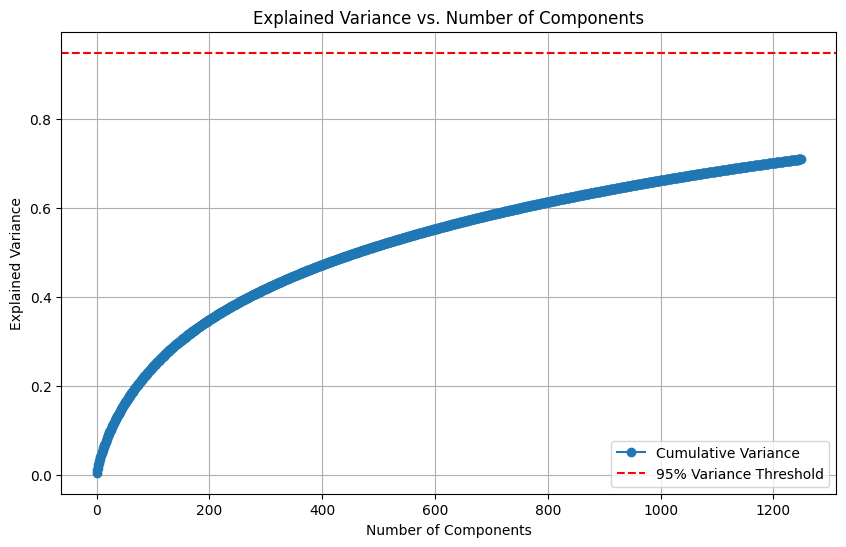

In [ ]:
# @title Plot SVD
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', label="Cumulative Variance")
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance Threshold")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.legend()
plt.grid()
plt.show()


## Models Collaborative

In [ ]:
# @title AutoEncoder

# --- AutoEncoder model ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, dim_feedforward, dropout, num_layers_encoder=1, num_layers_decoder=1):
        super(Autoencoder, self).__init__()

        # --- Encoder ---
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_dim, dim_feedforward))    # [batch_size, input_dim] -> [batch_size, dim_fwd]
        encoder_layers.append(nn.BatchNorm1d(dim_feedforward))          # [batch_size, dim_fwd] -> [batch_size, dim_fwd]
        encoder_layers.append(nn.ReLU())                                # [batch_size, dim_fwd] -> [batch_size, dim_fwd]
        encoder_layers.append(nn.Dropout(dropout))                      # [batch_size, dim_fwd] -> [batch_size, dim_fwd]

        for _ in range(num_layers_encoder - 2):  # -2 because we've already added two layers (1st ReLU and then Linear at the end)
            encoder_layers.append(nn.Linear(dim_feedforward, dim_feedforward))
            encoder_layers.append(nn.BatchNorm1d(dim_feedforward))
            encoder_layers.append(nn.ReLU())
            encoder_layers.append(nn.Dropout(dropout))

        encoder_layers.append(nn.Linear(dim_feedforward, latent_dim))   # [batch_size, dim_fwd] -> [batch_size, latent_dim]
        self.encoder = nn.Sequential(*encoder_layers)

        # --- Decoder ---
        decoder_layers = []                     # -2 because we've already added two layers (1st ReLU and then Linear at the end)
        decoder_layers.append(nn.Linear(latent_dim, dim_feedforward))
        decoder_layers.append(nn.BatchNorm1d(dim_feedforward))
        decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Dropout(dropout))

        for _ in range(num_layers_decoder - 2):
            decoder_layers.append(nn.Linear(dim_feedforward, dim_feedforward))
            decoder_layers.append(nn.BatchNorm1d(dim_feedforward))
            decoder_layers.append(nn.ReLU())
            decoder_layers.append(nn.Dropout(dropout))

        decoder_layers.append(nn.Linear(dim_feedforward, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        latent = self.encoder(x)                    # Input: [batch_size, input_dim] -> Latent: [batch_size, latent_dim]
        reconstructed = self.decoder(latent)        # Latent: [batch_size, latent_dim] -> Reconstructed: [batch_size, input_dim]
        return latent, reconstructed

def custom_loss(reconstructed, original, latent, sim_weight=0.01):
    mse_loss = criterion(reconstructed, original)  # Reconstruction loss (MSE)
    latent_normalized = F.normalize(latent, p=2, dim=1)  # Normalize embeddings

    # Compute self-similarity
    sim_loss = -torch.mean(F.cosine_similarity(latent_normalized, latent_normalized, dim=-1))
    return mse_loss + sim_weight * sim_loss

##########################
# --- Creating tensors on CPU only (could be done in a dataloader class as well)

# --- Now we pass the embeddings from the text vectorization as an input of the AutoEncoder
reduced_embeddings = torch.tensor(reduced_embeddings, dtype=torch.float)

# --- Categorical Feature (categoryName) ---
category_onehot = pd.get_dummies(data['categoryName'], prefix='category')
category_onehot_tensor = torch.tensor(category_onehot.values, dtype=torch.float)

# --- Categorical Features -> Price bins ---
price_bin_onehot = pd.get_dummies(data['price_range_bins'], prefix='price_range_bins')
price_bin_tensor = torch.tensor(price_bin_onehot.values, dtype=torch.float)

# --- Binary Feature ---
isBestSeller_tensor = torch.tensor(data['isBestSeller'].values, dtype=torch.float).unsqueeze(1)

# --- Numerical Feature ---
numerical_features_tensor = torch.tensor(data[numerical_features].values, dtype=torch.float)

# --- Concatenating everything in 1 tensor ---
# Kept everything on CPU before so it doesn/t blow up GPU's RAM
item_features = torch.cat((numerical_features_tensor, category_onehot_tensor, isBestSeller_tensor, price_bin_tensor, reduced_embeddings), dim=1)
##########################

# --- Variables ---
input_dim = item_features.shape[1] # Shape of the input dimension
print("Input Dim: ",input_dim)

dim_feedforward = 128       # hidden layers dimension
dropout = 0.5               # Regularization coeff
latent_dim = 500            # dimension of the latent space
batch_size = 262_144        # 65_536 #131_072 #262_144 #524_288 #16_384 #32_768
num_epochs = 130
num_layers_encoder=3        # Number of encoder layers
num_layers_decoder=3        # Number of decoder layers

# --- Model and Loss ---
model = Autoencoder(input_dim, latent_dim, dim_feedforward, dropout,num_layers_encoder, num_layers_decoder).to(device)
criterion = nn.MSELoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizer

# --- Initialize weights ---
for module in model.modules():
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight)
        nn.init.constant_(module.bias, 0)

# --- Dataloader ---
total_items = len(item_features)
train_size = int(0.7 * total_items) # 70% split
val_size = int(0.15 * total_items)   # 15% split
test_size = total_items - train_size - val_size # 10% split

dataset = TensorDataset(item_features)

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for batch in train_loader:
        item_features = batch[0].to(device)
        latent, reconstructed = model(item_features)
        # loss = criterion(reconstructed, item_features)
        loss = custom_loss(reconstructed, item_features, latent)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            item_features = batch[0].to(device)
            latent, reconstructed = model(item_features)
            loss = custom_loss(reconstructed, item_features, latent)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# --- Get item embeddings ---
model.eval()
item_embeddings = []
with torch.no_grad():
    for batch in test_loader:
        batch_features = batch[0].to(device)
        latent, _ = model(batch_features)
        item_embeddings.append(latent.cpu().numpy())

# --- Concatenate all batch results ---
item_embeddings = np.vstack(item_embeddings)

# --- L2-normalize the n-dim embeddings, like with the content based model
item_features = normalize(item_embeddings, norm='l2', axis=1)
## GPUs application
d = item_features.shape[1]
res = faiss.StandardGpuResources()  # Use a single GPU

index_flat = faiss.IndexFlatIP(d)   # CPU index
index = faiss.index_cpu_to_gpu(res, 0, index_flat)  # 0 = GPU device id

# --- Add all vectors ---
index.add(item_features)      # shape [N, d], float32
top_10 = 10                   # # number of closest neighbors we want to keep.
distances_colab, indices_colab = index.search(item_features, top_10) # distances and indices both shape: [N, k]

print("distances_colab shape:", distances_colab.shape)
print("indices_colab shape:", indices_colab.shape)

# --- Example for the first item
print("Item 0 neighbors:", indices_colab[0])
print("Item 0 distances_colab (IP ~ Cosine):", distances_colab[0])

Input Dim:  582
Epoch 1, Train Loss: 1.8112, Validation Loss: 0.0437
Epoch 2, Train Loss: 1.5056, Validation Loss: 0.0406
Epoch 3, Train Loss: 1.1818, Validation Loss: 0.0460
Epoch 4, Train Loss: 0.9431, Validation Loss: 0.0498
Epoch 5, Train Loss: 0.7396, Validation Loss: 0.0512
Epoch 6, Train Loss: 0.5902, Validation Loss: 0.0491
Epoch 7, Train Loss: 0.4639, Validation Loss: 0.0460
Epoch 8, Train Loss: 0.3850, Validation Loss: 0.0433
Epoch 9, Train Loss: 0.3011, Validation Loss: 0.0402
Epoch 10, Train Loss: 0.2525, Validation Loss: 0.0371
Epoch 11, Train Loss: 0.2169, Validation Loss: 0.0343
Epoch 12, Train Loss: 0.1892, Validation Loss: 0.0319
Epoch 13, Train Loss: 0.1655, Validation Loss: 0.0297
Epoch 14, Train Loss: 0.1487, Validation Loss: 0.0280
Epoch 15, Train Loss: 0.1302, Validation Loss: 0.0264
Epoch 16, Train Loss: 0.1205, Validation Loss: 0.0251
Epoch 17, Train Loss: 0.1074, Validation Loss: 0.0240
Epoch 18, Train Loss: 0.0974, Validation Loss: 0.0235
Epoch 19, Train Loss:

## Hybrid model: Combining Content Based and Collaborative Based filtering

In [ ]:
# @title Hybrid Recommendations
import random
def get_hybrid_recommendations(item_index, content_indices, collab_indices, content_weight=0.5, top_n=10):
    """
    Combines content-based and collaborative filtering recommendations.

    Args:
        item_index: Index of the item for which to generate recommendations.
        content_indices: Matrix of content-based recommendation indices (from KNN).
        collab_indices: Matrix of collaborative filtering recommendation indices (from Autoencoder similarity).
        content_weight: Weight given to content-based recommendations (between 0 and 1).

    Returns:
        A list of hybrid recommendation indices.
    """

    #Limit top n to available recommendations
    top_n = min(top_n, len(content_indices[item_index]), len(collab_indices[item_index]))


    content_recs = content_indices[item_index][:top_n]
    collab_recs = collab_indices[item_index][:top_n]

    # --- Create a dictionary to store scores for each recommended item ---
    hybrid_scores = {}

    # --- Score content-based recommendations ---
    for i, rec_index in enumerate(content_recs):
        score = content_weight * (top_n - i)
        hybrid_scores[rec_index] = hybrid_scores.get(rec_index, 0.0) + score

    # --- Score collaborative recommendations ---
    for i, rec_index in enumerate(collab_recs):
        score = (1 - content_weight) * (top_n - i)
        hybrid_scores[rec_index] = hybrid_scores.get(rec_index, 0.0) + score

    # --- Sort recommendations by score (descending) ---
    sorted_hybrid_recs = sorted(
        hybrid_scores.items(), # Get key-value pairs (recommendations with scores)
        key=lambda x: x[1],  #Sort by score (which is the second element in the tuple)
        reverse=True
    )

    # --- Extract indices and scores ---
    valid_recs = [(idx, score) for idx, score in sorted_hybrid_recs if idx < len(content_indices)]
    recommended_indices = [item[0] for item in valid_recs[1:top_n+1]]
    recommended_scores = [item[1] for item in valid_recs[1:top_n+1]]

    # Could add filtering / price bins in the recommendations

    return recommended_indices, recommended_scores

# --- Example usage (modified to create a DataFrame) ---
top_n = 10 # define top_n here
random_item_index = random.randint(0, len(indices_colab) - 1) # generate random index

# --- Calls the hybrid function that merges content and collab recommendation. Content weight is the weight applied to content based recommendations
content_weight = 0.75
hybrid_recommendations_indices, hybrid_recommendations_scores  = get_hybrid_recommendations(random_item_index, indices_content, indices_colab, content_weight=content_weight, top_n=top_n)

# --- Get the ASINs of the recommended items ---
hybrid_recommendations_asins = data['asin'].iloc[hybrid_recommendations_indices].tolist()

# --- Create a DataFrame with product info and recommendations ---
random_product_id = data['asin'].iloc[random_item_index]  # Get ASIN for the item_index
product_info = data[data['asin'] == random_product_id]
print("Randomly Selected asin: \n", product_info[['asin', 'title', 'categoryName']].values)

# --- Create a df with recommendations ---
recommendations_df = pd.DataFrame({'asin': hybrid_recommendations_asins})

# --- Merge with original data to get other attributes ---
recommendations_df = pd.merge(recommendations_df, data, on='asin', how='left')

# --- Concatenate the product info with the recommendations ---
final_recommendations_df = pd.concat([product_info, recommendations_df], axis=0)

# --- De-standardize for better interpretation ---
output_df = final_recommendations_df.copy()

# --- Reverse scaling for the numerical features in the recommendations ---
for feature in numerical_features:
    mean = scaler.mean_[numerical_features.index(feature)]
    scale = scaler.scale_[numerical_features.index(feature)]
    output_df[feature] = output_df[feature] * scale + mean
output_df[['asin', 'title', 'stars'	,'reviews'	,'price',	'listPrice',	'categoryName',	'isBestSeller'	,'boughtInLastMonth']]

Randomly Selected asin: 
 [['B07KNR3P2X'
  'men warm 2 1 hat winter fleece earflap skull sport beanie ski mask'
  'men accessory']]


,asin,title,stars,reviews,price,listPrice,categoryName,isBestSeller,boughtInLastMonth
32846,B07KNR3P2X,men warm 2 1 hat winter fleece earflap skull s...,4.4,455.0,28.00,0.000000,men accessory,False,0.0
0,B07HSSRQRF,men womens warm fleece beanie earflap winter h...,4.3,740.0,22.53,0.000000,men accessory,False,0.0
1,B081YYGYNS,men winter balaclava hood thin face ski mask g...,4.5,99.0,7.93,0.000000,snow ice sport,False,0.0
2,B09DCHXB81,beanie hat men womensoft wram slouchy ski ther...,4.3,148.0,18.99,0.000000,men accessory,False,0.0
3,B08JGWPJDC,men winter trapper hat snow hat thermal aviato...,4.0,181.0,24.72,0.000000,men accessory,False,0.0
4,B07J1L11M5,trooper trapper hat men winter windproof warm ...,4.0,157.0,24.99,0.000000,men accessory,False,0.0
5,B0BG3YHV27,ski mask thermal fleece balaclava ski face mas...,4.6,520.0,39.99,0.000000,men,False,0.0
6,B07YNGYVMD,men trapper hat bomber hat winter trooper usha...,4.4,340.0,23.43,0.000000,men accessory,False,0.0
7,B093Z1MJKT,moon chain necklace 18k white gold plated silv...,4.4,98.0,23.99,0.000000,men jewelry,False,0.0
8,B003VSGQPG,rokinon fe14mc 14mm f28 ultra wide lens canon ...,4.0,2615.0,374.72,414.940002,camera photo,False,0.0


In [ ]:
# @title Content Based Recommendations Only
print("\nDataFrame for Content Based Recommendation ONLY:")
# --- Extracts Content based recommendations only ---
content_recommendations_df = pd.DataFrame({'asin': data['asin'].iloc[indices_content[random_item_index]].tolist()})
content_recommendations_df = pd.merge(content_recommendations_df, data, on='asin', how='left')
# --- Create a copy to de-standardize the values ---
output_content_recommendations_df = content_recommendations_df.copy()

# --- Reverse scaling for numerical features ---
for feature in numerical_features:
    mean = scaler.mean_[numerical_features.index(feature)]
    scale = scaler.scale_[numerical_features.index(feature)]
    output_content_recommendations_df[feature] = (
        output_content_recommendations_df[feature] * scale + mean
    )

output_content_recommendations_df[['asin', 'title', 'stars'	,'reviews'	,'price',	'listPrice',	'categoryName',	'isBestSeller'	,'boughtInLastMonth']]


DataFrame for Content Based Recommendation ONLY:


,asin,title,stars,reviews,price,listPrice,categoryName,isBestSeller,boughtInLastMonth
0,B07KNR3P2X,men warm 2 1 hat winter fleece earflap skull s...,4.4,455.0,28.00,0.0,men accessory,False,0.0
1,B07HSSRQRF,men womens warm fleece beanie earflap winter h...,4.3,740.0,22.53,0.0,men accessory,False,0.0
2,B081YYGYNS,men winter balaclava hood thin face ski mask g...,4.5,99.0,7.93,0.0,snow ice sport,False,0.0
3,B09DCHXB81,beanie hat men womensoft wram slouchy ski ther...,4.3,148.0,18.99,0.0,men accessory,False,0.0
4,B08JGWPJDC,men winter trapper hat snow hat thermal aviato...,4.0,181.0,24.72,0.0,men accessory,False,0.0
5,B07J1L11M5,trooper trapper hat men winter windproof warm ...,4.0,157.0,24.99,0.0,men accessory,False,0.0
6,B0BG3YHV27,ski mask thermal fleece balaclava ski face mas...,4.6,520.0,39.99,0.0,men,False,0.0
7,B07YNGYVMD,men trapper hat bomber hat winter trooper usha...,4.4,340.0,23.43,0.0,men accessory,False,0.0
8,B07X38WHYR,men winter beanie hat scarf set warm fleece li...,4.6,1170.0,27.39,0.0,men accessory,False,0.0
9,B0CDH2M2V8,men winter trapper hat warm winter bomber hat ...,3.9,195.0,34.99,0.0,men accessory,False,0.0


In [ ]:
# @title Collaborative Based Recommendations Only
print("\nDataFrame for Collaborative Based Recommendation ONLY:")
collab_recommendations_df = pd.DataFrame({'asin': data['asin'].iloc[indices_colab[random_item_index]].tolist()})
collab_recommendations_df = pd.merge(collab_recommendations_df, data, on='asin', how='left')

# --- Create a copy to de-standardize the values ---
output_collab_recommendations_df = collab_recommendations_df.copy()

# --- Reverse scaling for numerical features ---
for feature in numerical_features:
    mean = scaler.mean_[numerical_features.index(feature)]
    scale = scaler.scale_[numerical_features.index(feature)]
    output_collab_recommendations_df[feature] = (
        output_collab_recommendations_df[feature] * scale + mean
    )

output_collab_recommendations_df[['asin', 'title', 'stars'	,'reviews'	,'price',	'listPrice',	'categoryName',	'isBestSeller'	,'boughtInLastMonth']]


DataFrame for Collaborative Based Recommendation ONLY:


,asin,title,stars,reviews,price,listPrice,categoryName,isBestSeller,boughtInLastMonth
0,B07KNR3P2X,men warm 2 1 hat winter fleece earflap skull s...,4.4,455.0,28.00,0.000000,men accessory,False,0.0
1,B093Z1MJKT,moon chain necklace 18k white gold plated silv...,4.4,98.0,23.99,0.000000,men jewelry,False,0.0
2,B003VSGQPG,rokinon fe14mc 14mm f28 ultra wide lens canon ...,4.0,2615.0,374.72,414.940002,camera photo,False,0.0
3,B07C4ZXGKG,medvance tm hydrocolloid bordered hydrocolloid...,4.3,262.0,33.49,0.000000,health care product,False,0.0
4,B08W8B9NYB,soges kitchen baker rack kitchen cart utility ...,4.5,162.0,119.99,0.000000,kitchen storage organization,False,0.0
5,B00DT3QNKQ,nivea creme 400 ml nivea,4.7,4737.0,21.95,0.000000,skin care product,False,0.0
6,B08SC6W1BB,womens chillax leather fashion sneaker,4.1,142.0,90.00,0.000000,womens shoe,False,0.0
7,B09C8W872K,vevor solar panel bird wire 6inch x 98ft critt...,4.3,120.0,104.59,0.000000,outdoor power lawn equipment,False,0.0
8,B07GBB8534,gerzwy swivel towel bar sus 304 stainless stee...,4.5,1132.0,43.50,0.000000,hardware,False,0.0
9,B08BP9LHLY,flicker flame light bulb clear flame tip cande...,4.3,255.0,21.99,0.000000,industrial scientific,False,50.0


## Evaluation Metrics

In [ ]:
# @title Coverage and Diversity metrics

# --- Lack of user centric metrics prevent use to create evaluation metrics like Precision@k or Recall@k ---
def coverage_score(indices_matrix, full_data_size):
    """
    Percentage of unique items that appear in any top-k list across all items.
    indices_matrix: shape [N, k]
    """
    recommended_items = set(indices_matrix.flatten())
    coverage = len(recommended_items) / full_data_size
    return coverage

def average_diversity(indices_matrix, embeddings):
    """
    Measures how dissimilar (on average) the top-k recommended items
    are from each other, across all items. We'll compute the average
    pairwise distance in embedding space for each top-k list, then average
    over all items.
    """
    n_items, k = indices_matrix.shape
    total_diversity = 0.0

    # --- For each item, compute average pairwise distance among the recommended items
    for i in range(n_items):
        recs = indices_matrix[i]
        # --- Extract the embeddings for these recommended items
        rec_vectors = embeddings[recs]  # shape: [k, d]
        if k > 1:
            # Compute pairwise distances: simple approach (L2 or 1 - cosine)
            # Here, we do dot product => if normalized, dot => cos similarity
            # so distance = 1 - cosSimilarity
            # We then do a quick pairwise approach
            sims = rec_vectors @ rec_vectors.T  # shape [k, k]
            # diag = 1.0 for each item with itself, so ignore it
            # Does the upper-tri
            tri_indices = np.triu_indices(k, 1)
            pair_sims = sims[tri_indices]  # similarity
            pair_dists = 1.0 - pair_sims
            avg_dist = pair_dists.mean()
            total_diversity += avg_dist
        else:
            # if k=1, there's only one item => no diversity
            total_diversity += 0.0

    return total_diversity / n_items

# Evaluate coverage & diversity for content-based alone:
content_coverage = coverage_score(indices_content, len(data))
content_diversity = average_diversity(indices_content, reduced_embeddings)
print("\n[Content-based] coverage =", content_coverage)
print("[Content-based] diversity =", content_diversity)

# Evaluate coverage & diversity for collab alone:
collab_coverage = coverage_score(indices_colab, len(test_loader.dataset))
collab_diversity = average_diversity(indices_colab, item_features)
print("\n[Collaborative] coverage =", collab_coverage)
print("[Collaborative] diversity =", collab_diversity)



[Content-based] coverage = 0.9999391096848514
[Content-based] diversity = tensor(0.2142)

[Collaborative] coverage = 1.0
[Collaborative] diversity = 0.1284697298921515


## Export CSV

In [ ]:
# @title Export CSV with recommendations and scores on Test Dataset

recommendation_results = []
print(len(test_dataset))
# --- Iterate over all items in the dataset
for item_index in range(len(test_dataset)):
    # Get recommendations and scores for the current item
    hybrid_recommendations_indices, hybrid_recommendations_scores = get_hybrid_recommendations(
        item_index,
        indices_content,
        indices_colab,
        content_weight=content_weight,
        top_n=top_n
    )

    # Map the recommended indices to ASINs
    recommended_asins = data['asin'].iloc[hybrid_recommendations_indices].tolist()

    # Append results as a dictionary
    recommendation_results.append({
        'asin': data['asin'].iloc[item_index],
        'recommendations': ', '.join(recommended_asins),
        'scores': ', '.join([f"{score:.4f}" for score in hybrid_recommendations_scores])
    })

# Convert results to a DataFrame
recommendation_df = pd.DataFrame(recommendation_results)

output_file = "/content/drive/Othercomputers/My Laptop/Documents/LT-RecommendationSystem/hybrid_recommendations.csv"
recommendation_df.to_csv(output_file, index=False)
print(f"Exported recommendations with scores to {output_file}")

print("\n END!")

91148
Exported recommendations with scores to /content/drive/Othercomputers/My Laptop/Documents/LT-RecommendationSystem/hybrid_recommendations.csv

 END!
